In [208]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br
# from gwbench.snr import scalar_product_freq_array

import time

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import optimize
from scipy import interpolate
from scipy import integrate

import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform


In [209]:
import matplotlib.pyplot as plt

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.size": 14
# })

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [210]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))

def inner_prod(h1, h2, Sn, f):
    x=f
    y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn
    interp_func = interpolate.interp1d(x, y, kind='cubic')
    # Define the integration limits
    a = x[0]
    b = x[-1]
    result, error = integrate.quadrature(interp_func, a, b, maxiter=100)
    return 2*np.real(result)

def inner_prod_normed(h1, h2, Sn, f):
    x=f
    a = x[0]
    b = x[-1]

    y1= h1*np.conjugate(h1) / Sn
    interp_func1 = interpolate.interp1d(x, y1, kind='cubic')
    h1_norm, error = integrate.quadrature(interp_func1, a, b, maxiter=100)
    h1_norm = 4*np.real(h1_norm)

    y2= h2*np.conjugate(h2) / Sn
    interp_func2 = interpolate.interp1d(x, y2, kind='cubic')
    h2_norm, error = integrate.quadrature(interp_func2, a, b, maxiter=100)
    h2_norm = 4*np.real(h2_norm)

    y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn
    interp_func = interpolate.interp1d(x, y, kind='cubic')
    result, error = integrate.quadrature(interp_func, a, b, maxiter=100)

    return 2*np.real(result / (np.sqrt(h1_norm * h2_norm)))


def maximize_overlap(params, args):
    tc, phic = params
    inj_params, f_low, f_high, d_f, approx2, network_spec_d, h1, Sn, f, deriv_symbs_string = args
    if (np.abs(phic)>np.pi):
        return np.inf
    
    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic

    net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant=approx2, network_spec=network_spec_d,
    calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
    
    h2 = net_2_try.detectors[0].hf
    return 1- np.abs(inner_prod_simps_normed(h1, h2, Sn, f))



def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

# def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
#     return np.array([ scalar_product_freq_array(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

# def scalar_product_freq_array(hf, gf, psd, freqs):
#     return np.real(integrate.simpson(scalar_product_integrand(hf, gf, psd), freqs))

# def scalar_product_integrand(hf, gf, psd):
#     temp = np.multiply(hf, np.conj(gf))
#     return 2 * np.divide(temp + np.conj(temp), psd)



# Arnab's Binary

In [428]:
network_label = 'HLV+'
 
inj_params = dict()
inj_params['Mc'] = 30.9
inj_params['eta'] = 0.247
inj_params['iota'] = np.pi/4
inj_params['chi1x'] = 0
inj_params['chi1y'] = 0
inj_params['chi1z'] = 0
inj_params['chi2x'] = 0
inj_params['chi2y'] = 0
inj_params['chi2z'] = 0
inj_params['DL'] = 475
inj_params['tc'] = 0
inj_params['phic'] = 0
inj_params['ra'] = np.pi/4
inj_params['dec'] = np.pi/4
inj_params['psi'] = np.pi/4
inj_params['gmst0'] = 0
inj_params['phiRef'] = 0

# d_f = 1/16
d_f = 2**-4
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)

conv_cos = ('iota','dec')
conv_log = ('Mc','DL')
 
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
deriv_variables = ['log_Mc', 'eta', 'log_DL', 'tc', 'phic', 'cos_iota', 'ra', 'cos_dec', 'psi']

arnab_opt_bias = np.array([-1.31714324e-03, -2.53070629e-03, -1.29260647e-02, 2.33387974e-04, -2.43714891e-02, -8.23804703e-03, 4.42655777e-05, -1.40069160e-05, -2.42399781e-02])

arnab_unopt_bias = np.array([1.30937195e-02, 3.38632109e-02, 1.74124245e+00, -2.14910145e-03, 3.90542706e-01, 2.64436484e-01, -1.87088785e-03, 8.53396225e-04, -6.38689364e-02])

In [519]:
net_ap = network.Network(network_spec=network_label)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})


use_rot = 0

net_ap.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-5, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-5, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()


net_tr = network.Network(network_spec=network_label)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()

2023-12-25 12:43:39,725 - Network - INFO : Polarizations calculated.
2023-12-25 12:43:39,726 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-25 12:43:39,731 - Network - INFO : Polarizations calculated.
2023-12-25 12:43:44,404 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-25 12:43:44,429 - Network - INFO : PSDs loaded.
2023-12-25 12:43:44,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:43:44,444 - Network - INFO : Detector responses calculated.
2023-12-25 12:43:44,445 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-25 12:43:44,445 - Network - INFO :    A+_H
2023-12-25 12:43:47,666 - Network - INFO :    A+_L
2023-12-25 12:43:50,833 - Network - INFO :    V+_V
2023-12-25 12:43:53,979 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-25 12:43:53,984 - Network - INFO : SNRs calculated.
2023-12-25 12:43:53,984 - Network - INFO : Calculate errors (Fishe

In [430]:
print(net_ap.det_keys)
net_ap.errs

['A+_H', 'A+_L', 'V+_V']


{'log_Mc': 0.0017209775,
 'eta': 0.001993467,
 'log_DL': 0.277842,
 'tc': 0.000110126006,
 'phic': 1.2589339,
 'cos_iota': 0.2937757,
 'ra': 0.0066693784,
 'cos_dec': 0.004860321,
 'psi': 0.65569746}

In [431]:
arnab_errs = net_ap.errs.copy()
arnab_errs['Mc'] = inj_params['Mc']* net_ap.errs['log_Mc']
arnab_errs['DL'] = inj_params['DL']* net_ap.errs['log_DL']
arnab_errs['iota'] = net_ap.errs['cos_iota']/np.sin(inj_params['iota'])
arnab_errs['dec'] = net_ap.errs['cos_dec']/np.sin(inj_params['dec'])
arnab_errs

{'log_Mc': 0.0017209775,
 'eta': 0.001993467,
 'log_DL': 0.277842,
 'tc': 0.000110126006,
 'phic': 1.2589339,
 'cos_iota': 0.2937757,
 'ra': 0.0066693784,
 'cos_dec': 0.004860321,
 'psi': 0.65569746,
 'Mc': 0.05317820417694747,
 'DL': 131.9749429821968,
 'iota': 0.4154615898186222,
 'dec': 0.006873531960289314}

# Compute Unoptimized biases

In [432]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

for d in range(len(net_ap.detectors)):
    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr.detectors[d].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)


cv_bias = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias = np.array(cv_bias.tolist()[0])

log_Mc: 8.914%
eta: 4.219%
log_DL: 0.119%
tc: -12.059%
phic: 56.165%
cos_iota: 4.732%
ra: -15.826%
cos_dec: 8.796%
psi: -139.416%


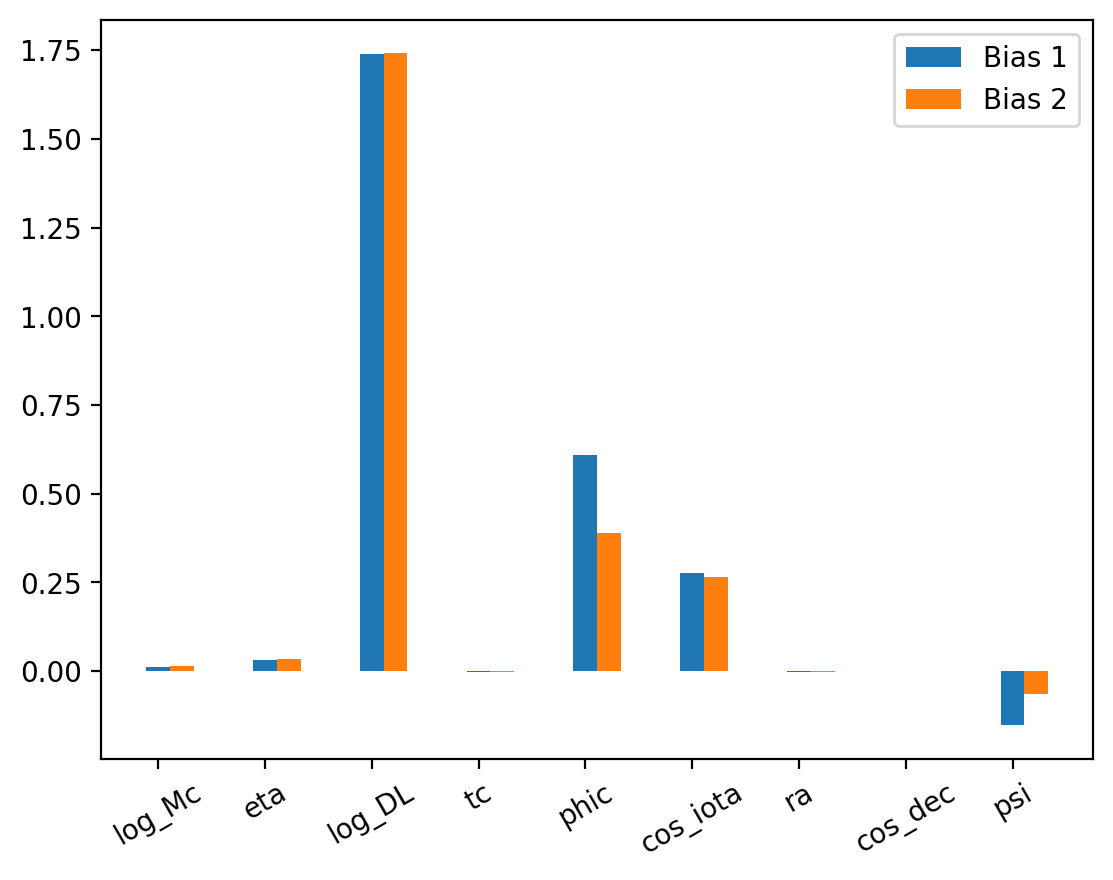

log_Mc, 1: 0.012 
log_Mc, 2: 0.013 

eta, 1: 0.032 
eta, 2: 0.034 

log_DL, 1: 1.739 
log_DL, 2: 1.741 

tc, 1: -0.002 
tc, 2: -0.002 

phic, 1: 0.610 
phic, 2: 0.391 

cos_iota, 1: 0.277 
cos_iota, 2: 0.264 

ra, 1: -0.002 
ra, 2: -0.002 

cos_dec, 1: 0.001 
cos_dec, 2: 0.001 

psi, 1: -0.153 
psi, 2: -0.064 



In [433]:
for n, bias in enumerate(100*np.abs(arnab_unopt_bias-cv_bias)/arnab_unopt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias
bias2 = arnab_unopt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Compute Optimized Biases

## Scipy Optimize Way

In [94]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

# separate_det_opt = False
for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]


    ## optimize tc and phic
    args = [inj_params, f_low, f_high, d_f, 'IMRPhenomD', network_spec_d, h1, Sn, f, deriv_symbs_string]
    initial=[-0.004, -1.1]

    result = minimize(maximize_overlap, initial, args=args, method='BFGS')
    
    tc_opt, phic_opt = result.x
    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -tc_opt
    inj_params_opt_d['phic'] = -phic_opt
    
    
    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    # print("Inner product:")
    # print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))
    
    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

2023-12-24 14:53:41,014 - Network - INFO : Polarizations calculated.


2023-12-24 14:53:41,024 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,043 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,047 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,062 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,070 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,080 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,083 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,096 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,162 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,172 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,176 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,188 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:41,219 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,225 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,235 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,238 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,251 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,257 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,260 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,266 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,269 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,283 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,290 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,299 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,302 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:41,414 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,421 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,431 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,449 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,479 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,487 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,496 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,499 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,513 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,520 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,530 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,533 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:41,685 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,693 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,704 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,708 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,724 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,731 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,742 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,745 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,759 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,768 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,780 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,785 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:41,883 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,893 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,897 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,911 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,918 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,929 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,933 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,949 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:41,959 - Network - INFO : PSDs loaded.
2023-12-24 14:53:41,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:41,973 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:41,978 - Network - INFO : SNRs calculated.
2023-12-24 14:53:41,998 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:42,132 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,164 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,172 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,194 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,204 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,220 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,224 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,246 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,256 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,271 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,276 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,296 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:42,394 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,406 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,420 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,425 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,446 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,458 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,473 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,478 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,499 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,510 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,525 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,530 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 14:53:42,652 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,664 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,682 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,688 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,711 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,723 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,739 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,745 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,769 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,780 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,796 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,807 - Network - INFO : Polarizat

['A+_H']
['A+_H']
Inner product:
-0.9993902512893929


2023-12-24 14:53:42,863 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,874 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,892 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,898 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,918 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,930 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:42,946 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:42,951 - Network - INFO : SNRs calculated.
2023-12-24 14:53:42,973 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:42,984 - Network - INFO : PSDs loaded.
2023-12-24 14:53:42,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,000 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,005 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:43,079 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,113 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,124 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,147 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,153 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,176 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,188 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,206 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,213 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,238 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,252 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,269 - Network - INFO : Detector responses calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:43,307 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,324 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,329 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,351 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,361 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,376 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,381 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,401 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,411 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,425 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,430 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,450 - Network - INFO : Polarizations calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:43,561 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,574 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,592 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,597 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,622 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,634 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,650 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,655 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,676 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,687 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,702 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,707 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:43,757 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,780 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,818 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,838 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,853 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,858 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,879 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,891 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:43,908 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:43,913 - Network - INFO : SNRs calculated.
2023-12-24 14:53:43,936 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:43,948 - Network - INFO : PSDs loaded.
2023-12-24 14:53:43,954 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:44,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,024 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,030 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,052 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,064 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,080 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,086 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,108 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,120 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,136 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,142 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,162 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,174 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:44,244 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,263 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,274 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,287 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,292 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,311 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,321 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,335 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,340 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,359 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,369 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,383 - Network - INFO : Detector responses calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:44,458 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,468 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,483 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,488 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,508 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,519 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,532 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,537 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,556 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,567 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,581 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,605 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:44,709 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,721 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,735 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,740 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,760 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,771 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,786 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,791 - Network - INFO : SNRs calculated.
2023-12-24 14:53:44,811 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,821 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,836 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:44,841 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-24 14:53:44,965 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:44,976 - Network - INFO : PSDs loaded.
2023-12-24 14:53:44,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:44,996 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,002 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,024 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,035 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,050 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,054 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,076 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,088 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,104 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,116 - Network - INFO : Polarizat

['A+_L']
['A+_L']
Inner product:
-0.9993902512893441


2023-12-24 14:53:45,173 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,194 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,209 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,214 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,234 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,253 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,267 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,273 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,292 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,313 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,329 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,335 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:45,378 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,399 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,404 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,437 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,517 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,536 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,546 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,572 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,594 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,609 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,614 - Network - INFO : SNRs calculated.


['V+_V']
['V+_V']


2023-12-24 14:53:45,639 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,662 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,680 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,686 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,709 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,730 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,745 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,751 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,771 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,790 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,806 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,811 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:45,832 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,853 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,868 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,875 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,899 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,920 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:45,936 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:45,942 - Network - INFO : SNRs calculated.
2023-12-24 14:53:45,964 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:45,985 - Network - INFO : PSDs loaded.
2023-12-24 14:53:45,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,000 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,005 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:46,103 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,117 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,123 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,142 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,161 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,175 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,180 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,200 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,218 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,232 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,237 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,256 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:46,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,347 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,352 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,394 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,547 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,564 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,570 - Network - INFO : SNRs calculated.


['V+_V']


2023-12-24 14:53:46,594 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,616 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,635 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,640 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,662 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,685 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,702 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,708 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,729 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,752 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,775 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,780 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:46,804 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,825 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,841 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,846 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,870 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,891 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,907 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,912 - Network - INFO : SNRs calculated.
2023-12-24 14:53:46,932 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:46,954 - Network - INFO : PSDs loaded.
2023-12-24 14:53:46,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:46,971 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:46,976 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:46,996 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,017 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,032 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,038 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,060 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,081 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,100 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,105 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,126 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,147 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,162 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,168 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:47,254 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,276 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,293 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,299 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,323 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,346 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,363 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,370 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,392 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,416 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,433 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,441 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:47,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,550 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,555 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,576 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,598 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,616 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,622 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,645 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,666 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,681 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,686 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,707 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,728 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:47,777 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,798 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,813 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,820 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,842 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,861 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,877 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,882 - Network - INFO : SNRs calculated.
2023-12-24 14:53:47,902 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:47,924 - Network - INFO : PSDs loaded.
2023-12-24 14:53:47,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:47,942 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:47,950 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:48,033 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,056 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,073 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,078 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,102 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,130 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,149 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,155 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,178 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,197 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,211 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,216 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:48,311 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,324 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,328 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,347 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,365 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,379 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,383 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,402 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,421 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,435 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,439 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,459 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:48,543 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,562 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,575 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,580 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,599 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,618 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,631 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,636 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,655 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,673 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,687 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,691 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:48,797 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,802 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,821 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,840 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,856 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,861 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,880 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,900 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:48,914 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:48,919 - Network - INFO : SNRs calculated.
2023-12-24 14:53:48,938 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:48,958 - Network - INFO : PSDs loaded.
2023-12-24 14:53:48,962 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:49,015 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,030 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,035 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,054 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,073 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,087 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,091 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,110 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,129 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,142 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,147 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,166 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:49,252 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,257 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,278 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,296 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,309 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,314 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,334 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,354 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,369 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,374 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,394 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,418 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,441 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:49,472 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,494 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,525 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,543 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,550 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,572 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,593 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,610 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,616 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,637 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,658 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,676 - Network - INFO : Detector responses calc

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:49,706 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,892 - Network - INFO : PSDs loaded.


['V+_V']


2023-12-24 14:53:49,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,910 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,915 - Network - INFO : SNRs calculated.
2023-12-24 14:53:49,942 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:49,963 - Network - INFO : PSDs loaded.
2023-12-24 14:53:49,969 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:49,980 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:49,986 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,006 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,028 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,044 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,050 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,071 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,092 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:50,153 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,168 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,173 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,193 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,212 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,225 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,230 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,251 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,270 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,284 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,289 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,309 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:50,386 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,400 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,404 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,424 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,443 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,457 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,461 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,481 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,500 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,514 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,520 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,539 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:50,636 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,664 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,677 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,683 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,702 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,721 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,735 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,740 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,759 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,778 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,792 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,797 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:50,836 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,850 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,855 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,875 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,893 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,906 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,911 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,930 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:50,949 - Network - INFO : PSDs loaded.
2023-12-24 14:53:50,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:50,963 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:50,968 - Network - INFO : SNRs calculated.
2023-12-24 14:53:50,987 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:51,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,077 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,082 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,102 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,120 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,134 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,139 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,158 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,177 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,190 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,195 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,214 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,232 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:51,303 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,308 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,327 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,346 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,360 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,365 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,384 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,403 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,416 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,421 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,440 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,458 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,463 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:51,529 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,534 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,553 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,571 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,585 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,590 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,609 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,628 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,641 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,646 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,666 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,685 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,697 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:51,757 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,776 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,791 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,796 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,815 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,834 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,848 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,853 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,873 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:51,891 - Network - INFO : PSDs loaded.
2023-12-24 14:53:51,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,904 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,909 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:51,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:51,960 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:51,965 - Network - INFO : SNRs calculated.
2023-12-24 14:53:51,985 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,003 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,017 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,022 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,041 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,060 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,073 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,078 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,096 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,115 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:52,185 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,190 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,209 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,312 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,326 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,331 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,350 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,369 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,383 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,388 - Network - INFO : SNRs calculated.


['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:52,407 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,425 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,439 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,444 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,464 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,483 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,497 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,502 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,521 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,539 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,553 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,558 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:52,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,667 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,672 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,691 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,710 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,742 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,747 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,770 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,788 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,801 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,806 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,825 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,844 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:52,900 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,913 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,918 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,937 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:52,955 - Network - INFO : PSDs loaded.
2023-12-24 14:53:52,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:52,968 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:52,972 - Network - INFO : SNRs calculated.
2023-12-24 14:53:52,992 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,010 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,025 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,030 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,048 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:53,135 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,140 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,159 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,177 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,191 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,195 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,213 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,231 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,245 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,249 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,269 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,287 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,292 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:53,357 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,362 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,382 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,401 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,415 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,420 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,439 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,457 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,470 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,475 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,494 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,513 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,517 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:53,582 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,586 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,606 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,624 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,637 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,642 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,660 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,679 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,713 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,718 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,742 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,761 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,766 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:53,799 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,819 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,833 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,838 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,857 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,876 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,889 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,894 - Network - INFO : SNRs calculated.
2023-12-24 14:53:53,913 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:53,931 - Network - INFO : PSDs loaded.
2023-12-24 14:53:53,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:53,945 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:53,950 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:54,058 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,062 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,081 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,099 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,113 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,118 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,136 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,239 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,253 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,258 - Network - INFO : SNRs calculated.


['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:54,277 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,296 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,310 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,315 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,335 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,353 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,367 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,371 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,390 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,409 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,423 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,427 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:54,535 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,539 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,558 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,577 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,590 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,595 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,614 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,632 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,645 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,668 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,697 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,718 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,723 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:54,758 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,778 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,792 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,797 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,817 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,837 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,850 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,855 - Network - INFO : SNRs calculated.
2023-12-24 14:53:54,874 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:54,892 - Network - INFO : PSDs loaded.
2023-12-24 14:53:54,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:54,906 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:54,911 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:55,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,019 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,024 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,043 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,062 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,075 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,080 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,099 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,118 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,132 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,137 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,156 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,175 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:55,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,245 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,251 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,270 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,289 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,303 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,307 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,326 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,346 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,359 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,364 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,383 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,401 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:55,472 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,477 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,498 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,517 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,531 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,536 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,555 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,573 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,587 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,592 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,611 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,630 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,634 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:55,693 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,721 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,726 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,745 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,852 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,867 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,872 - Network - INFO : SNRs calculated.
2023-12-24 14:53:55,891 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,910 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,924 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,929 - Network - INFO : SNRs calculated.


['V+_V']
['V+_V']


2023-12-24 14:53:55,950 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:55,968 - Network - INFO : PSDs loaded.
2023-12-24 14:53:55,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:55,984 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:55,988 - Network - INFO : SNRs calculated.
2023-12-24 14:53:56,009 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:56,029 - Network - INFO : PSDs loaded.
2023-12-24 14:53:56,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:56,045 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:56,050 - Network - INFO : SNRs calculated.
2023-12-24 14:53:56,070 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:56,089 - Network - INFO : PSDs loaded.
2023-12-24 14:53:56,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:56,103 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:56,108 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-24 14:53:56,148 - Network - INFO : PSDs loaded.
2023-12-24 14:53:56,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:56,161 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:56,165 - Network - INFO : SNRs calculated.
2023-12-24 14:53:56,184 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:56,203 - Network - INFO : PSDs loaded.
2023-12-24 14:53:56,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:56,217 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:56,222 - Network - INFO : SNRs calculated.
2023-12-24 14:53:56,243 - Network - INFO : Polarizations calculated.
2023-12-24 14:53:56,262 - Network - INFO : PSDs loaded.
2023-12-24 14:53:56,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 14:53:56,281 - Network - INFO : Detector responses calculated.
2023-12-24 14:53:56,291 - Network - INFO : Polarizations calculated.


['V+_V']
Inner product:
-0.99942626093366


In [96]:
print(1- result.fun)
print(result.x)

print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))

0.99942626093366
[-0.00454805 -1.028122  ]
-0.99942626093366


log_Mc: -180.504%
eta: -187.782%
log_DL: -12040.215%
tc: 134.810%
phic: -2099.715%
cos_iota: -5872.157%
ra: 10402.877%
cos_dec: -10668.386%
psi: -1089.597%


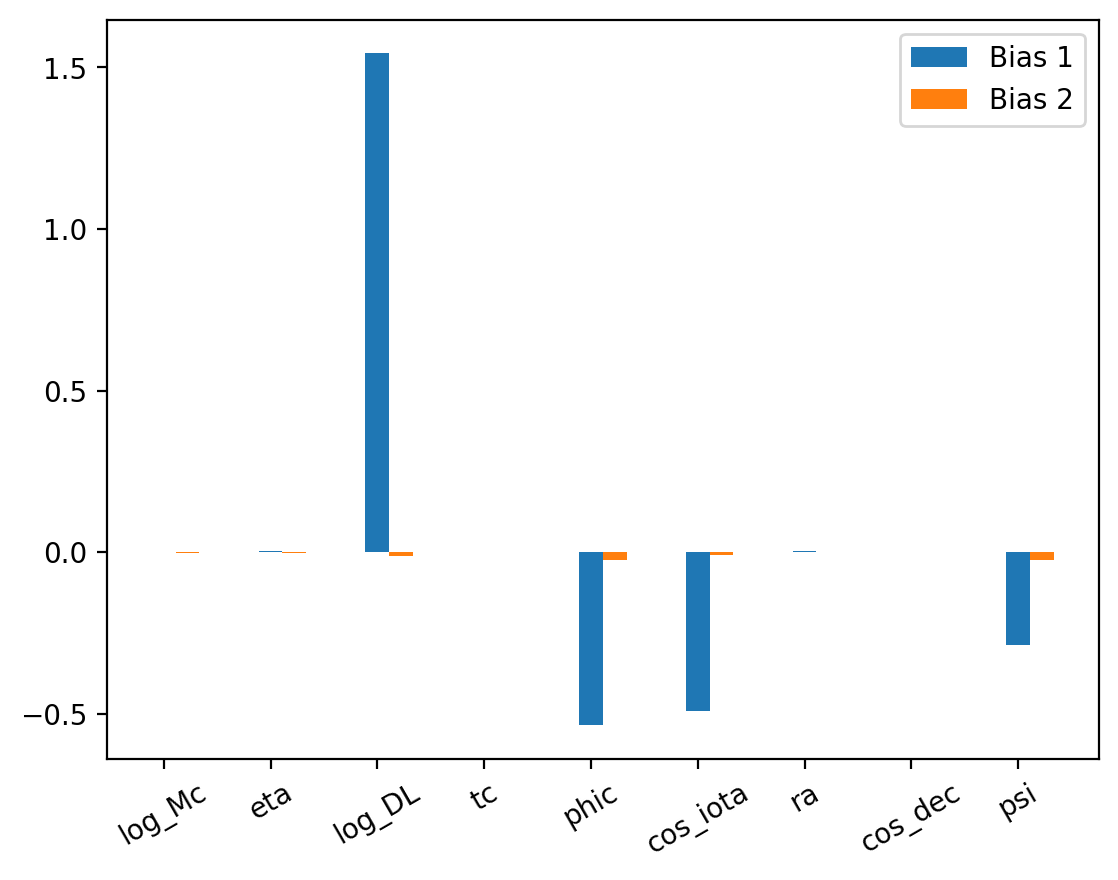

log_Mc, 1: 0.001 
log_Mc, 2: -0.001 

eta, 1: 0.002 
eta, 2: -0.003 

log_DL, 1: 1.543 
log_DL, 2: -0.013 

tc, 1: -0.000 
tc, 2: 0.000 

phic, 1: -0.536 
phic, 2: -0.024 

cos_iota, 1: -0.492 
cos_iota, 2: -0.008 

ra, 1: 0.005 
ra, 2: 0.000 

cos_dec, 1: 0.001 
cos_dec, 2: -0.000 

psi, 1: -0.288 
psi, 2: -0.024 



In [97]:
for n, bias in enumerate(100*np.abs(arnab_opt_bias-cv_bias_opt)/arnab_opt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias_opt
bias2 = arnab_opt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Compute Matched Filter Quantity

## single detector test

In [98]:
d = 0
h1 = net_tr.detectors[d].hf
h2 = net_ap.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

In [99]:
time_arr = np.linspace(-1., 1., 30001)
x_t0_re = np.zeros(len(time_arr))
x_t0_im = np.zeros(len(time_arr))

for i in range(len(time_arr)):
    t0 = time_arr[i]
    x_t0 = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
    x_t0_re[i] = np.real(x_t0)
    x_t0_im[i] = np.imag(x_t0)

In [133]:
max_idx = np.argmax(x_t0_re**2 + x_t0_im**2)
time_shift = time_arr[max_idx]
phase_shift = np.angle(x_t0_re + 1j*x_t0_im)[max_idx]/2

print(f"time shift: {time_shift} s")
print(f"phase shift: {phase_shift}")

time shift: 0.004533333333333278 s
phase shift: -1.0627039529706692


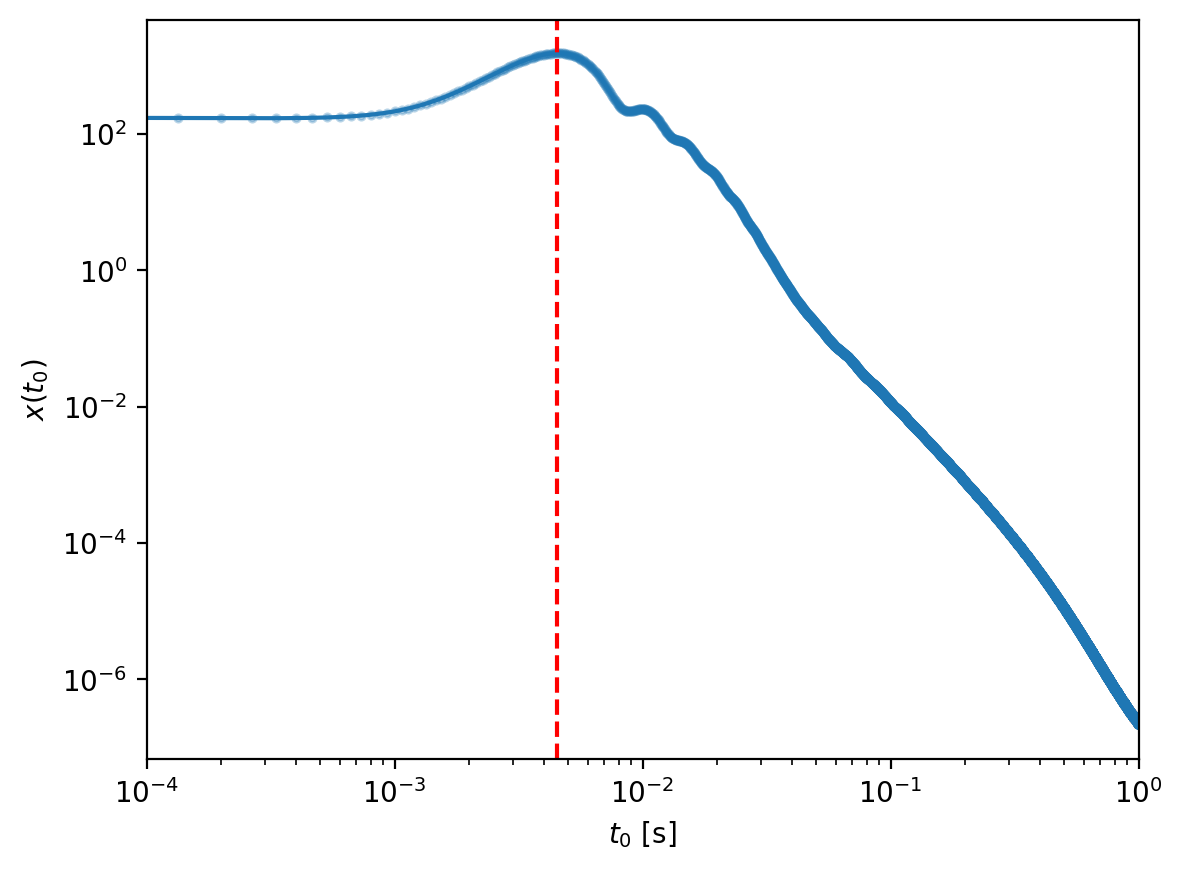

In [103]:
plt.plot(time_arr, x_t0_re**2 + x_t0_im**2)
plt.scatter(time_arr, x_t0_re**2 + x_t0_im**2, s=7, alpha=0.3)
plt.axvline(x=time_shift, ls='--', c='r')
plt.xlabel('$t_0$ [s]')
plt.ylabel("$x(t_0)$")
plt.loglog()
plt.xlim(1e-4, 1e0)
plt.show()

In [ ]:
d = 0

h1 = net_tr.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

inj_params_opt_d = inj_params.copy()
inj_params_opt_d['tc'] = time_shift # should be positive for matched filter
inj_params_opt_d['phic'] = -phase_shift  # should be negative for matched filter


net_tr_opt_d = network.Network(network_spec=network_spec_d)
net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
net_tr_opt_d.set_net_vars(
    f=f, inj_params=inj_params_opt_d,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr_opt_d.calc_wf_polarizations()
net_tr_opt_d.setup_ant_pat_lpf_psds()
net_tr_opt_d.calc_det_responses()
net_tr_opt_d.calc_wf_polarizations()

print("Inner product:")
print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))


## Compute Bias with matched filter phase and time shift

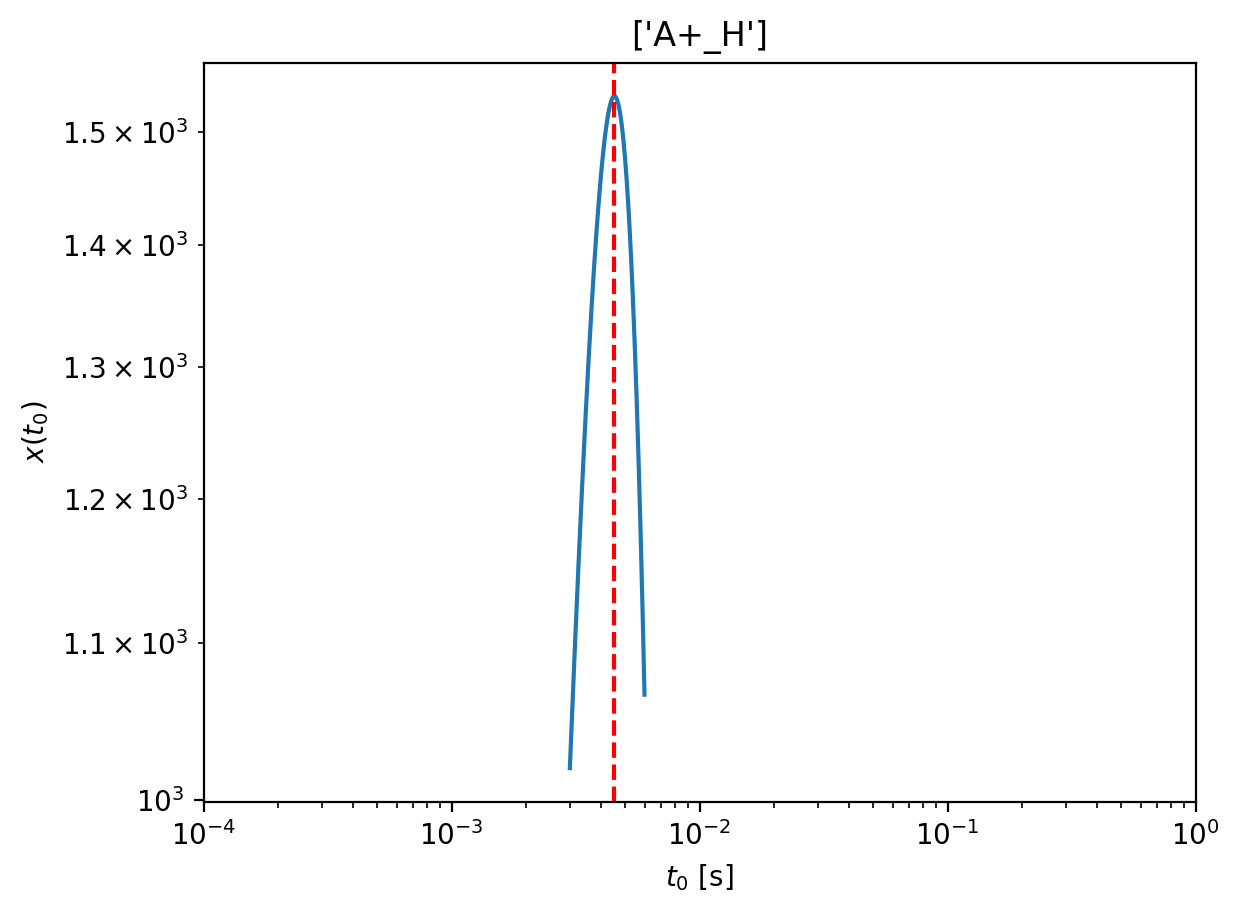

2023-12-25 11:40:53,484 - Network - INFO : Polarizations calculated.
2023-12-25 11:40:53,491 - Network - INFO : PSDs loaded.
2023-12-25 11:40:53,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 11:40:53,498 - Network - INFO : Detector responses calculated.
2023-12-25 11:40:53,504 - Network - INFO : Polarizations calculated.


time shift: 0.004536
phase shift: -2.1238192850181155
Inner product:
0.9993902513373188


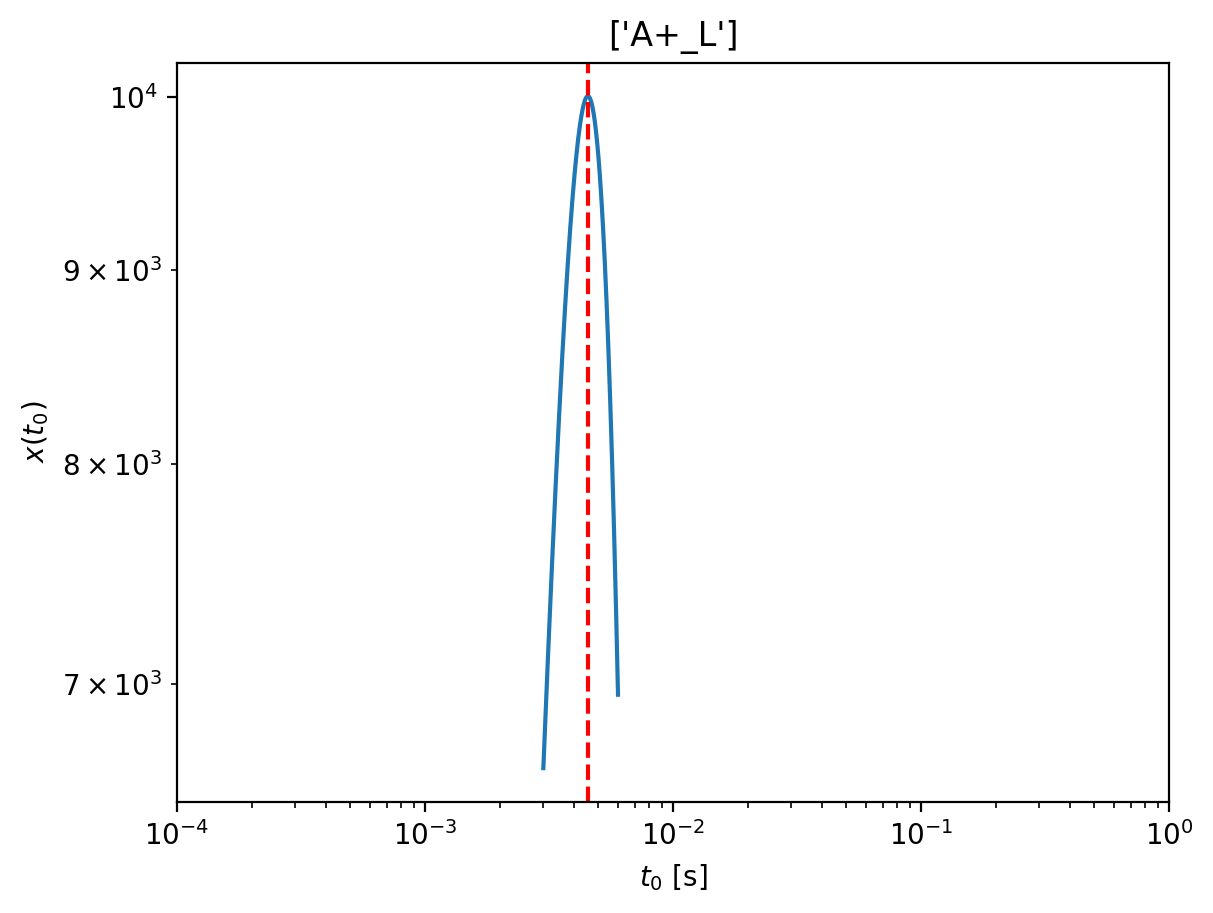

2023-12-25 11:40:56,083 - Network - INFO : Polarizations calculated.
2023-12-25 11:40:56,090 - Network - INFO : PSDs loaded.
2023-12-25 11:40:56,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 11:40:56,097 - Network - INFO : Detector responses calculated.
2023-12-25 11:40:56,102 - Network - INFO : Polarizations calculated.


time shift: 0.004536
phase shift: -2.1238192850181155
Inner product:
0.9993902513373187


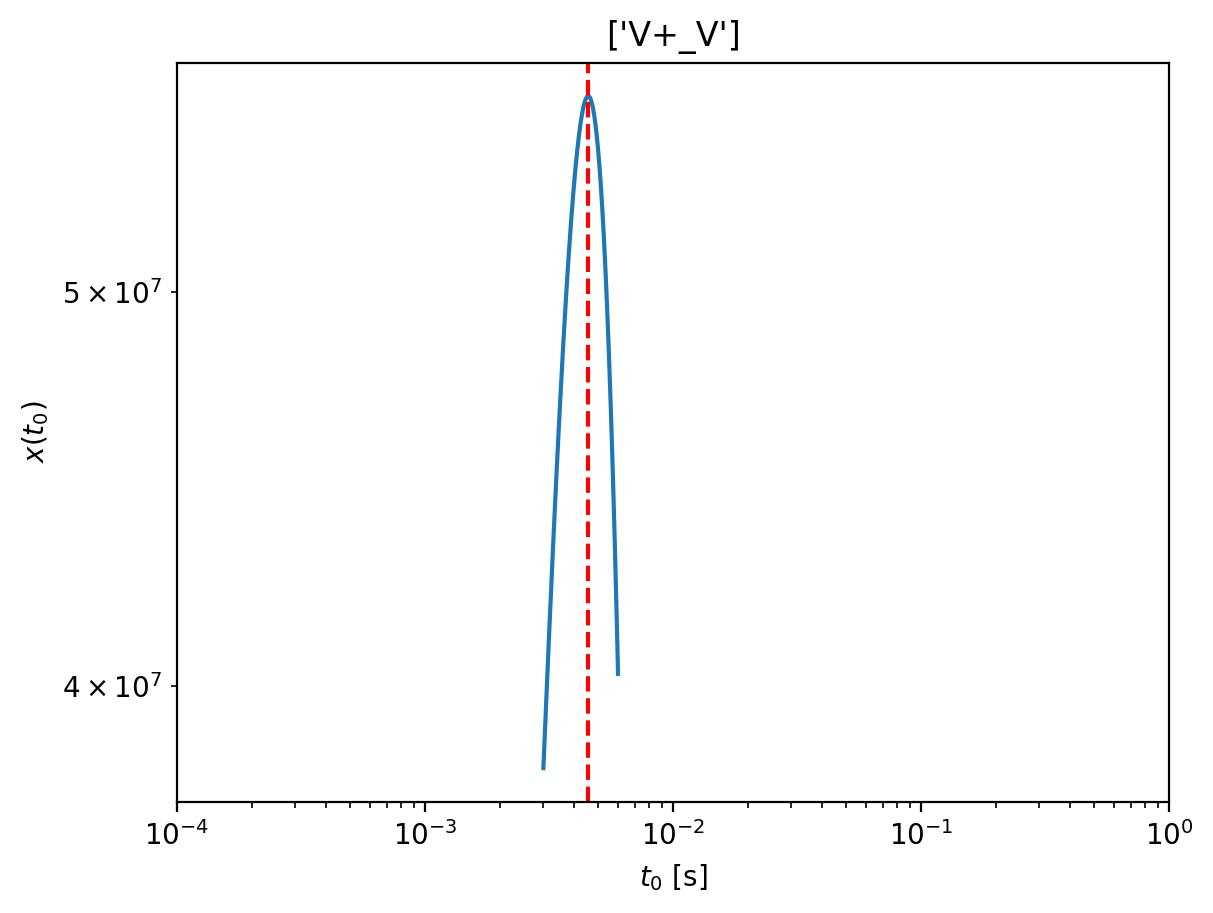

2023-12-25 11:40:58,754 - Network - INFO : Polarizations calculated.
2023-12-25 11:40:58,767 - Network - INFO : PSDs loaded.
2023-12-25 11:40:58,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 11:40:58,777 - Network - INFO : Detector responses calculated.
2023-12-25 11:40:58,782 - Network - INFO : Polarizations calculated.


time shift: 0.004548
phase shift: -2.1134958741396703
Inner product:
0.9994262608333546


In [443]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

time_arr_d = np.linspace(0.003, 0.006, 1001)


# separate_det_opt = False
for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i in range(len(time_arr_d)):
        t0 = time_arr_d[i]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i] = np.real(x_t0_d)
        x_t0_im_d[i] = np.imag(x_t0_d)

    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = np.unwrap(np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-4, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = phase_shift_d  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    print("Inner product:")
    print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

log_Mc: -12.109%
eta: -7.629%
log_DL: -106.273%
tc: 42.739%
phic: -143.114%
cos_iota: -183.151%
ra: 368.427%
cos_dec: -213.855%
psi: -156.990%


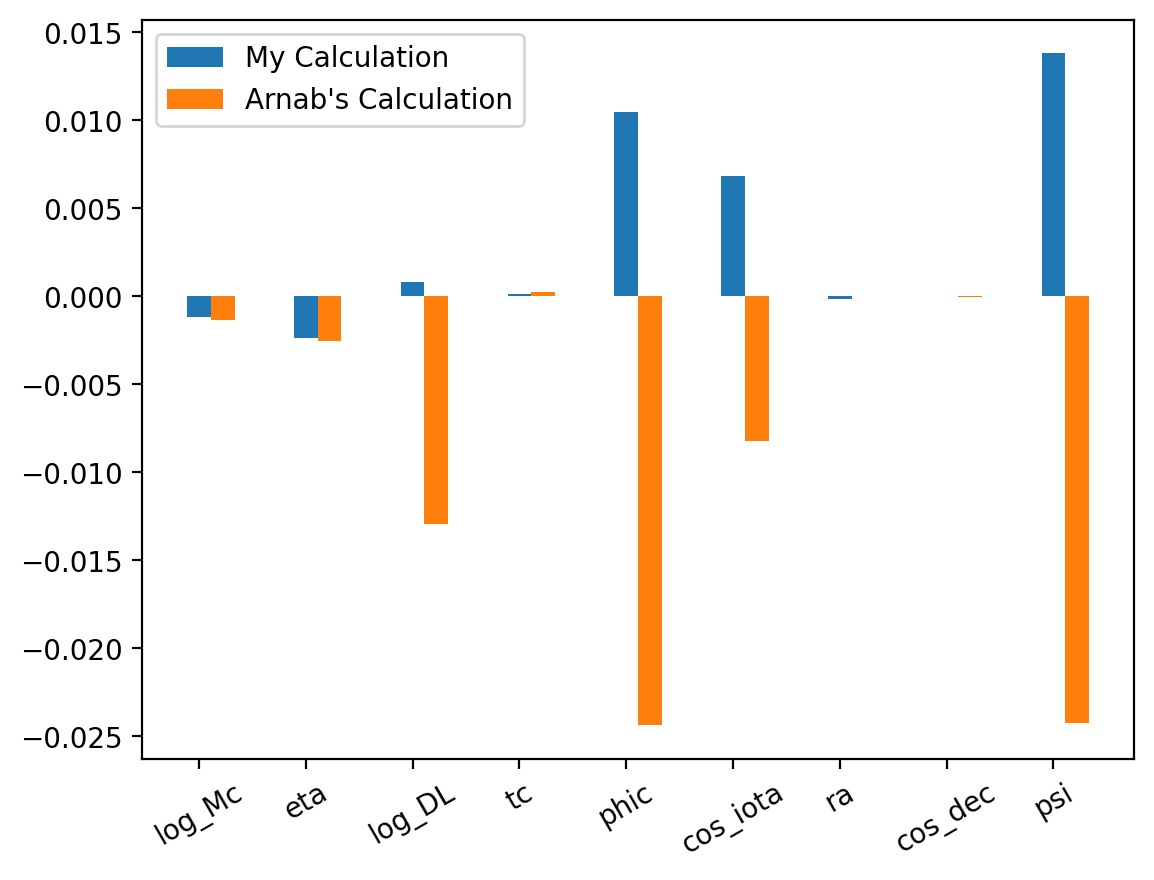

log_Mc, 1: -0.001 
log_Mc, 2: -0.001 

eta, 1: -0.002 
eta, 2: -0.003 

log_DL, 1: 0.001 
log_DL, 2: -0.013 

tc, 1: 0.000 
tc, 2: 0.000 

phic, 1: 0.011 
phic, 2: -0.024 

cos_iota, 1: 0.007 
cos_iota, 2: -0.008 

ra, 1: -0.000 
ra, 2: 0.000 

cos_dec, 1: 0.000 
cos_dec, 2: -0.000 

psi, 1: 0.014 
psi, 2: -0.024 



In [444]:
for n, bias in enumerate(100*np.abs(arnab_opt_bias-cv_bias_opt)/arnab_opt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias_opt
bias2 = arnab_opt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='My Calculation')
plt.bar(x+width, bias2, width=width, label="Arnab's Calculation")

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

## Is this quantity ~overlap?

In [129]:
time_arr_ip = np.geomspace(1e-5, 1e1, 1000)
inner_prods_time = np.zeros(len(time_arr_ip))

d = 0

h1 = net_tr.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

for i in range(len(time_arr_ip)):

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_arr_ip[i]
    inj_params_opt_d['phic'] = phase_shift
    
    
    net_ap_time_shift = network.Network(network_spec=network_spec_d)
    net_ap_time_shift.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_ap_time_shift.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_ap_time_shift.calc_wf_polarizations()
    net_ap_time_shift.setup_ant_pat_lpf_psds()
    net_ap_time_shift.calc_det_responses()
    net_ap_time_shift.calc_wf_polarizations()

    h2 = net_ap_time_shift.detectors[0].hf

    inner_prods_time[i] = inner_prod_simps_normed(h1, h2, Sn, f)
    

2023-12-24 15:10:56,628 - Network - INFO : Polarizations calculated.
2023-12-24 15:10:56,636 - Network - INFO : PSDs loaded.
2023-12-24 15:10:56,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:10:56,646 - Network - INFO : Detector responses calculated.
2023-12-24 15:10:56,652 - Network - INFO : Polarizations calculated.
2023-12-24 15:10:56,666 - Network - INFO : Polarizations calculated.
2023-12-24 15:10:56,674 - Network - INFO : PSDs loaded.
2023-12-24 15:10:56,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:10:56,684 - Network - INFO : Detector responses calculated.
2023-12-24 15:10:56,691 - Network - INFO : Polarizations calculated.
2023-12-24 15:10:56,703 - Network - INFO : Polarizations calculated.
2023-12-24 15:10:56,709 - Network - INFO : PSDs loaded.
2023-12-24 15:10:56,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:10:56,719 - Network - INFO : Detector responses calculated.
2023-12-24 15:10:56,726 - Network 

In [130]:
max_idx = np.argmax(np.abs(inner_prods_time))
max_idx
time_shift_ip = time_arr_ip[max_idx]

print(f"max overlap: {inner_prods_time[max_idx]}")
print(f"time shift: {time_shift_ip} s")

max overlap: -0.9990419408040666
time shift: 0.004577840538376616 s


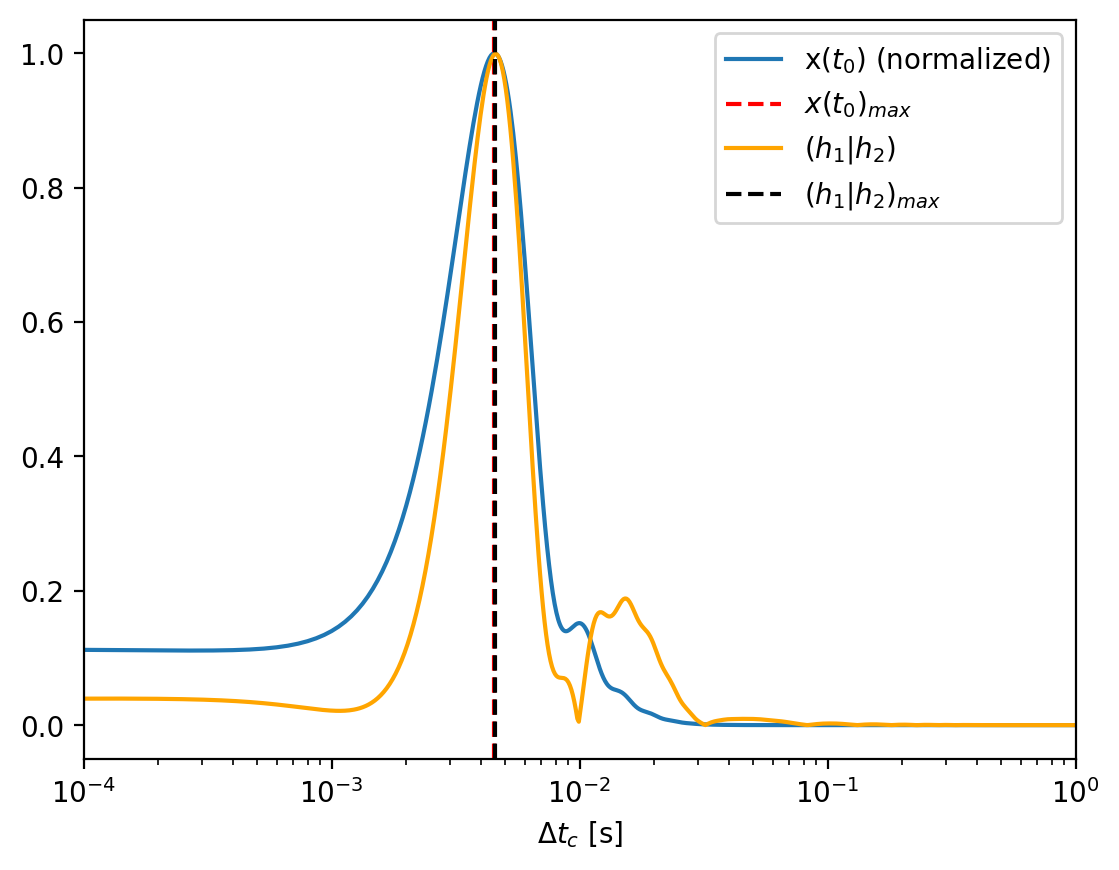

In [185]:
# plt.scatter(time_arr_ip, inner_prods_time, s=2, c='r')
plt.plot(time_arr, (x_t0_re**2 + x_t0_im**2)/np.max((x_t0_re**2 + x_t0_im**2)), label='x($t_0$) (normalized)')
plt.axvline(x=time_shift, ls='--', c='r', label='$x(t_0)_{max}$')


plt.plot(time_arr_ip, np.abs(inner_prods_time), c='orange', label='$(h_1 | h_2)$')
plt.axvline(x=time_shift_ip, ls='--', c='k', label='$(h_1 | h_2)_{max}$')

plt.xlabel('$\Delta t_c$ [s]')
# plt.ylabel("$(h_1 | h_2)$")
plt.semilogx()
plt.xlim(1e-4, 1e0)
plt.legend()

plt.show()

In [176]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

# separate_det_opt = False
for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_ip # should be positive for matched filter
    inj_params_opt_d['phic'] = -phase_shift  # should be negative for matched filter
    
    
    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

2023-12-24 15:25:48,907 - Network - INFO : Polarizations calculated.


2023-12-24 15:25:48,913 - Network - INFO : PSDs loaded.
2023-12-24 15:25:48,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:25:48,924 - Network - INFO : Detector responses calculated.
2023-12-24 15:25:48,932 - Network - INFO : Polarizations calculated.
2023-12-24 15:25:48,964 - Network - INFO : Polarizations calculated.
2023-12-24 15:25:48,972 - Network - INFO : PSDs loaded.
2023-12-24 15:25:48,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:25:48,982 - Network - INFO : Detector responses calculated.
2023-12-24 15:25:48,989 - Network - INFO : Polarizations calculated.
2023-12-24 15:25:49,018 - Network - INFO : Polarizations calculated.
2023-12-24 15:25:49,031 - Network - INFO : PSDs loaded.
2023-12-24 15:25:49,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 15:25:49,040 - Network - INFO : Detector responses calculated.
2023-12-24 15:25:49,047 - Network - INFO : Polarizations calculated.


log_Mc: -181.815%
eta: -188.731%
log_DL: -12093.274%
tc: 148.709%
phic: -2052.448%
cos_iota: -5779.317%
ra: 10012.368%
cos_dec: -10861.584%
psi: -986.977%


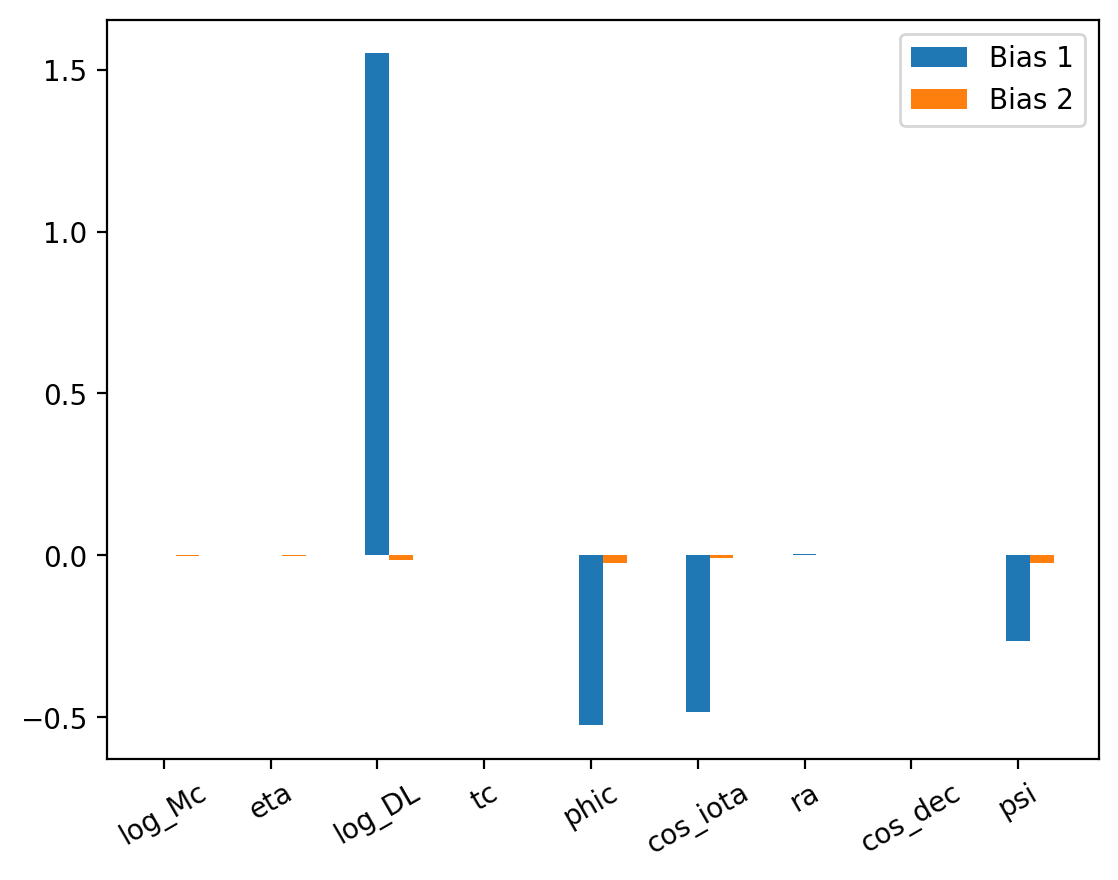

log_Mc, 1: 0.001 
log_Mc, 2: -0.001 

eta, 1: 0.002 
eta, 2: -0.003 

log_DL, 1: 1.550 
log_DL, 2: -0.013 

tc, 1: -0.000 
tc, 2: 0.000 

phic, 1: -0.525 
phic, 2: -0.024 

cos_iota, 1: -0.484 
cos_iota, 2: -0.008 

ra, 1: 0.004 
ra, 2: 0.000 

cos_dec, 1: 0.002 
cos_dec, 2: -0.000 

psi, 1: -0.263 
psi, 2: -0.024 



In [178]:
for n, bias in enumerate(100*np.abs(arnab_opt_bias-cv_bias_opt)/arnab_opt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias_opt
bias2 = arnab_opt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Plot the waveforms

In [413]:
d = 0
h1 = net_tr.detectors[d].hf
h2 = net_ap.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

time_arr_d = np.linspace(0.003, 0.006, 1001)
x_t0_re_d = np.zeros(len(time_arr_d))
x_t0_im_d = np.zeros(len(time_arr_d))

for i in range(len(time_arr_d)):
    t0 = time_arr_d[i]
    x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
    x_t0_re_d[i] = np.real(x_t0_d)
    x_t0_im_d[i] = np.imag(x_t0_d)

max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
time_shift_d = time_arr_d[max_idx]
phase_shift_d = np.angle(x_t0_re_d + 1j*x_t0_im_d)[max_idx]

print("time shift:", time_shift_d)
print("phase shift:", phase_shift_d)

inj_params_opt_d = inj_params.copy()
inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
inj_params_opt_d['phic'] = -phase_shift_d  # should be negative when shifting XAS to maximize overlap


net_tr_opt_d = network.Network(network_spec=network_spec_d)
net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
net_tr_opt_d.set_net_vars(
    f=f, inj_params=inj_params_opt_d,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr_opt_d.calc_wf_polarizations()
net_tr_opt_d.setup_ant_pat_lpf_psds()
net_tr_opt_d.calc_det_responses()
net_tr_opt_d.calc_wf_polarizations()

h2_opt = net_tr_opt_d.detectors[0].hf

print()

print("Inner product before aligning:")
print(np.abs(inner_prod_simps_normed(h1, h2, net_ap.detectors[d].psd, net_ap.detectors[d].f)))
print()
print("Inner product after aligning:")
print(np.abs(inner_prod_simps_normed(h1, h2_opt, net_ap.detectors[d].psd, net_ap.detectors[d].f)))


2023-12-25 11:29:14,725 - Network - INFO : Polarizations calculated.
2023-12-25 11:29:14,733 - Network - INFO : PSDs loaded.
2023-12-25 11:29:14,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 11:29:14,740 - Network - INFO : Detector responses calculated.
2023-12-25 11:29:14,745 - Network - INFO : Polarizations calculated.


time shift: 0.004536
phase shift: -2.1238192850181155

Inner product before aligning:
0.3110055411930568

Inner product after aligning:
0.9993902513373187


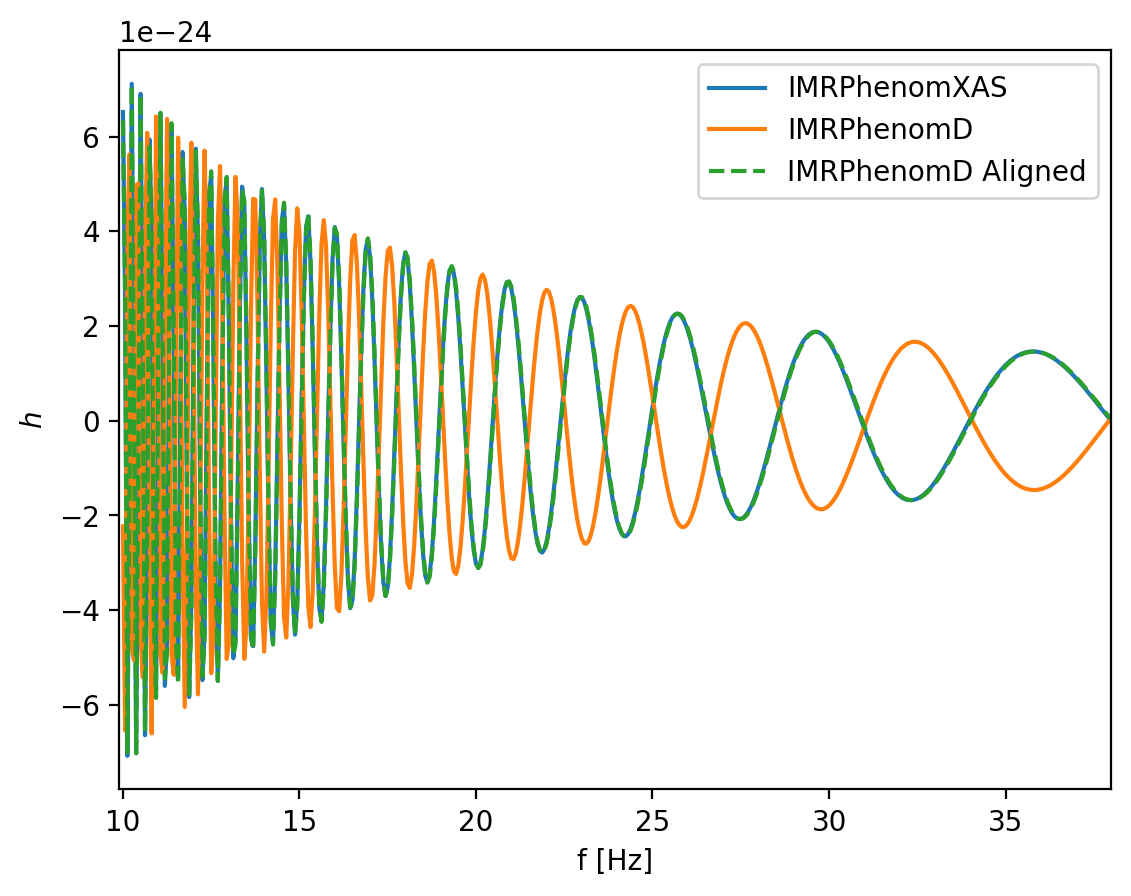

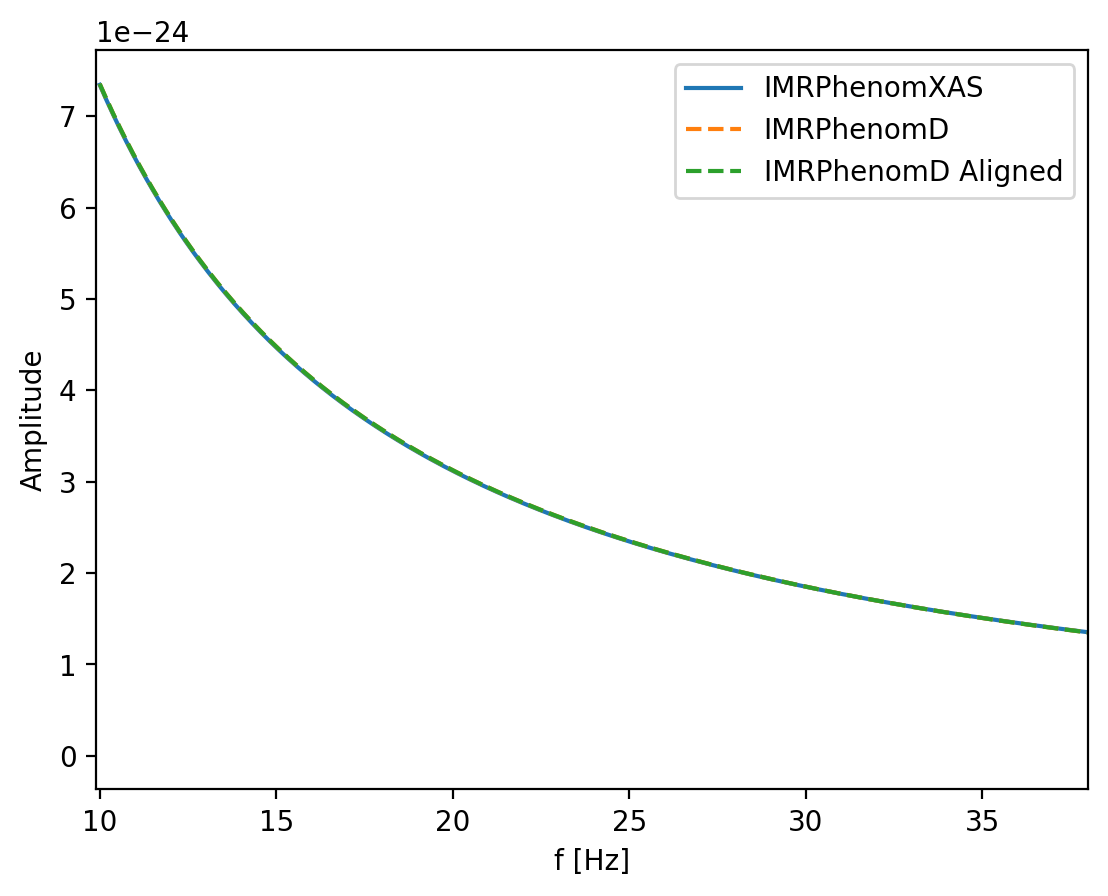

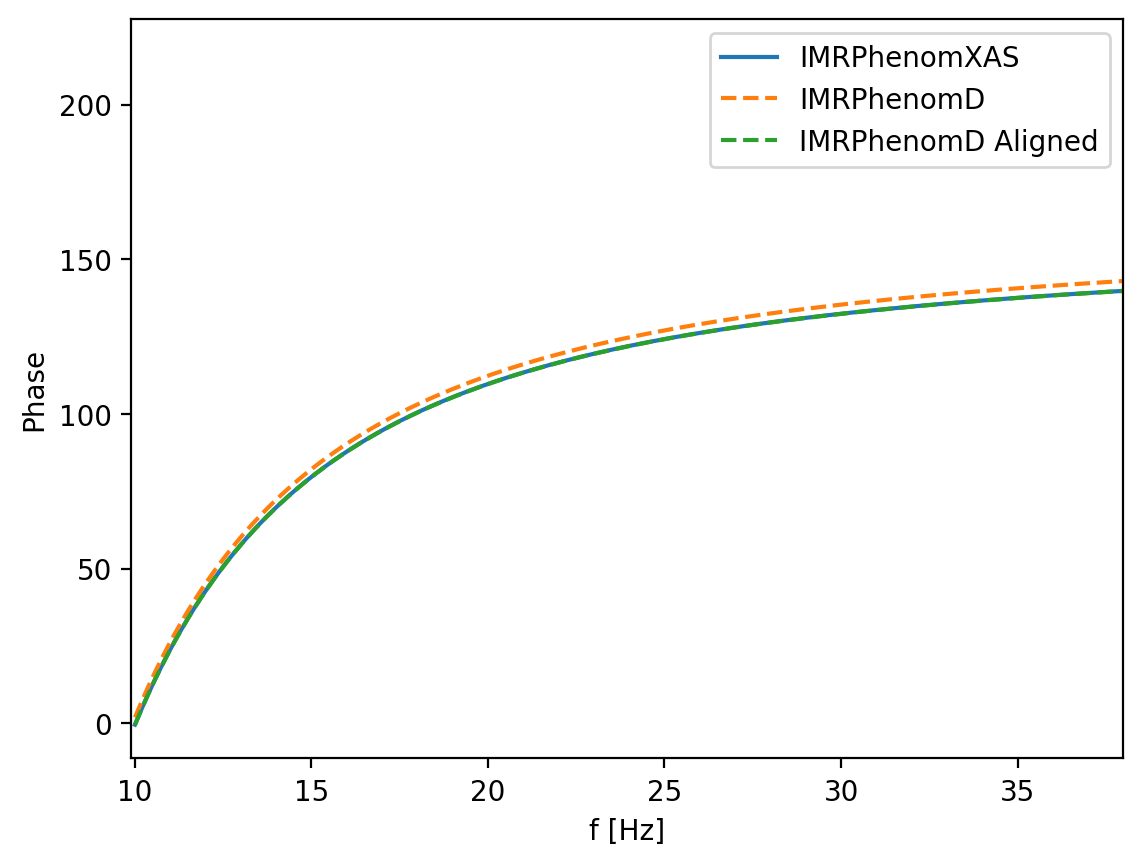

In [415]:
plt.plot(f, h1, label='IMRPhenomXAS')
plt.plot(f, h2, label='IMRPhenomD')
plt.plot(f, h2_opt,  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('$h$')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

# Amplitude
plt.plot(f, np.abs(h1), label='IMRPhenomXAS')
plt.plot(f, np.abs(h2), ls='--', label='IMRPhenomD')
plt.plot(f, np.abs(h2_opt),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

# Phase
plt.plot(f, np.unwrap(np.angle(h1)), label='IMRPhenomXAS')
plt.plot(f, np.unwrap(np.angle(h2)), ls='--', label='IMRPhenomD')
plt.plot(f, np.unwrap(np.angle(h2_opt)),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('Phase')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

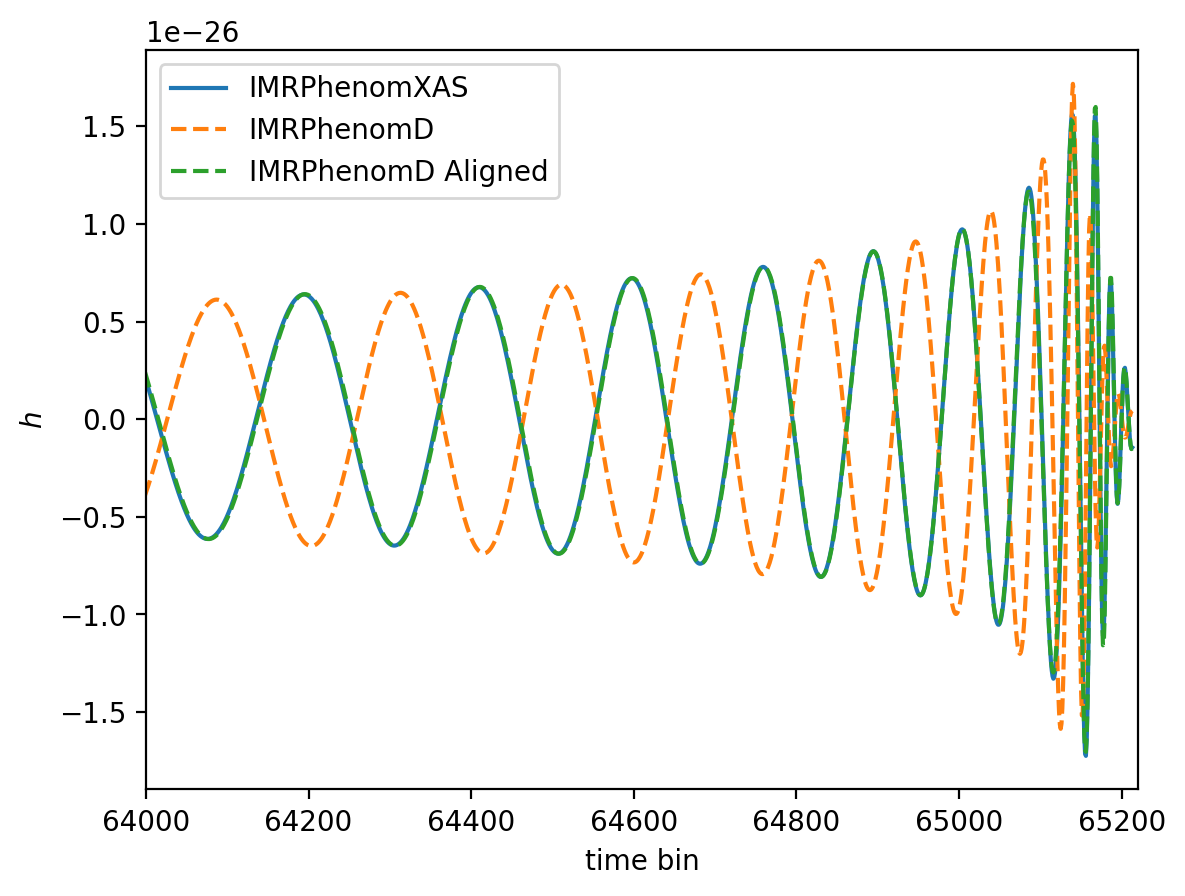

In [417]:
# Time Domain
plt.plot(np.fft.irfft(h1), label='IMRPhenomXAS')
plt.plot(np.fft.irfft(h2), ls='--', label='IMRPhenomD')
plt.plot(np.fft.irfft(h2_opt),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('time bin')
plt.ylabel('$h$')
plt.legend()
plt.xlim(64000, 65220)
plt.show()

# Aside: plot the DL bias dependence on phase shifts

In [527]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))


phis = np.linspace(-np.pi, 0.0, 50)
DL_biases = np.zeros(len(phis))
overlaps = np.zeros(len(phis))

for i in range(len(phis)):
    for d in range(len(net_ap.detectors)):
        ## set up initial waveforms
        h1 = net_tr.detectors[d].hf
        h2 = net_ap.detectors[d].hf
        f = net_ap.detectors[d].f
        Sn = net_ap.detectors[d].psd
        network_spec_d = [net_ap.detectors[d].det_key]

        phase_shift_test = phis[i]


        inj_params_opt_d = inj_params.copy()
        inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
        inj_params_opt_d['phic'] = phase_shift_test  # should be positive when shifting XAS to maximize overlap

        net_tr_opt_d = network.Network(network_spec=network_spec_d)
        net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
        net_tr_opt_d.set_net_vars(
            f=f, inj_params=inj_params_opt_d,
            deriv_symbs_string=deriv_symbs_string,
            conv_cos=conv_cos, conv_log=conv_log,
            use_rot=use_rot
            )
        net_tr_opt_d.calc_wf_polarizations()
        net_tr_opt_d.setup_ant_pat_lpf_psds()
        net_tr_opt_d.calc_det_responses()
        net_tr_opt_d.calc_wf_polarizations()


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

    cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
    cv_bias_opt = np.array(cv_bias_opt.tolist()[0])
    DL_biases[i] = cv_bias_opt[2]
    overlaps[i] = inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)



2023-12-25 12:45:16,394 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:16,401 - Network - INFO : PSDs loaded.
2023-12-25 12:45:16,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:45:16,408 - Network - INFO : Detector responses calculated.
2023-12-25 12:45:16,414 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:16,419 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:16,426 - Network - INFO : PSDs loaded.
2023-12-25 12:45:16,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:45:16,454 - Network - INFO : Detector responses calculated.
2023-12-25 12:45:16,465 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:16,482 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:16,505 - Network - INFO : PSDs loaded.
2023-12-25 12:45:16,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:45:16,521 - Network - INFO : Detector responses calculated.
2023-12-25 12:45:16,527 - Network 

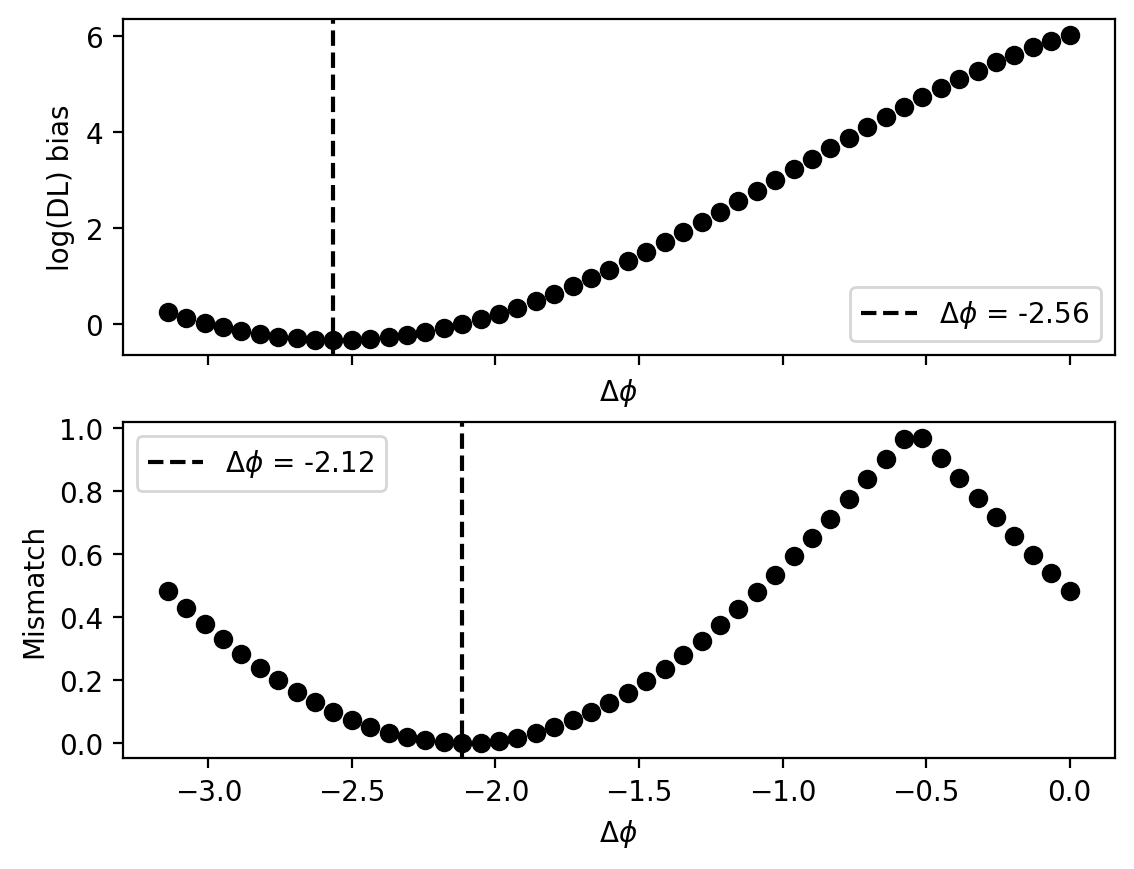

In [528]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].scatter(phis, DL_biases)
ax[0].set_xlabel("$\Delta \phi$")
ax[0].set_ylabel("log(DL) bias")
ax[0].axvline(x=phis[np.argmin(DL_biases)], c='k', ls='--', label=f'$\Delta \phi$ = {phis[np.argmin(DL_biases)]:.2f}')
ax[0].legend()

ax[1].scatter(phis, 1-np.abs(overlaps))
ax[1].set_xlabel("$\Delta \phi$")
ax[1].set_ylabel("Mismatch")
ax[1].axvline(x=phis[np.argmax(overlaps)], c='k', ls='--', label=f'$\Delta \phi$ = {phis[np.argmax(overlaps)]:.2f}')
ax[1].legend()
plt.show()

2023-12-25 12:29:13,297 - Network - INFO : Polarizations calculated.
2023-12-25 12:29:13,311 - Network - INFO : PSDs loaded.
2023-12-25 12:29:13,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:29:13,318 - Network - INFO : Detector responses calculated.
2023-12-25 12:29:13,325 - Network - INFO : Polarizations calculated.
2023-12-25 12:29:13,355 - Network - INFO : Polarizations calculated.
2023-12-25 12:29:13,367 - Network - INFO : PSDs loaded.
2023-12-25 12:29:13,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:29:13,373 - Network - INFO : Detector responses calculated.
2023-12-25 12:29:13,377 - Network - INFO : Polarizations calculated.
2023-12-25 12:29:13,395 - Network - INFO : Polarizations calculated.
2023-12-25 12:29:13,408 - Network - INFO : PSDs loaded.
2023-12-25 12:29:13,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:29:13,418 - Network - INFO : Detector responses calculated.
2023-12-25 12:29:13,423 - Network 

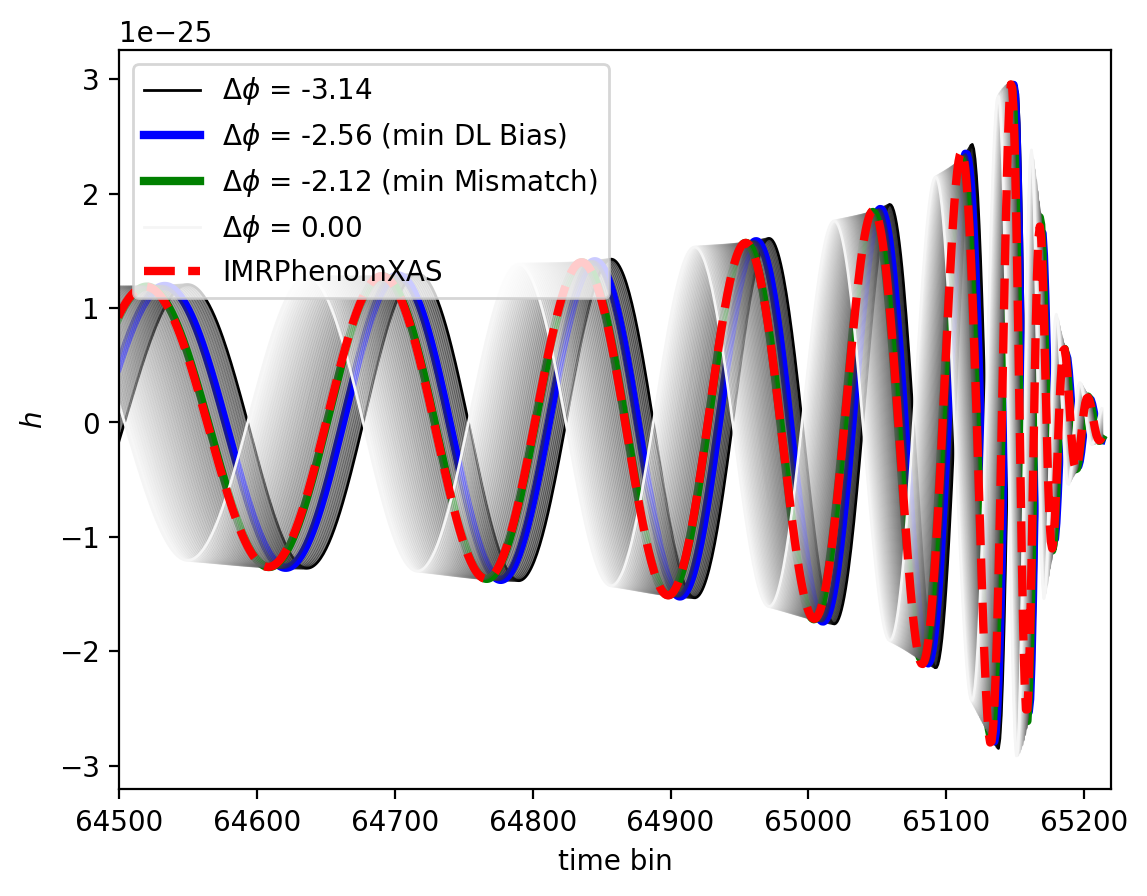

In [507]:
# Time Domain
d=0

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()
    h2_opt = net_tr_opt_d.detectors[0].hf

    if (i==0 or i+1==len(phis)):
        plt.plot(np.fft.irfft(h2_opt), lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
    elif (i==np.argmax(overlaps)):
        plt.plot(np.fft.irfft(h2_opt), lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
    elif (i==np.argmin(DL_biases)):
        plt.plot(np.fft.irfft(h2_opt), lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        plt.plot(np.fft.irfft(h2_opt), lw=1, alpha=0.5)

plt.plot(np.fft.irfft(h1), label='IMRPhenomXAS', c='r', ls='--', lw=3)
plt.xlabel('time bin')
plt.ylabel('$h$')
plt.legend()
plt.xlim(64500, 65220)
plt.show()

2023-12-25 12:45:39,376 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:39,390 - Network - INFO : PSDs loaded.
2023-12-25 12:45:39,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:45:39,397 - Network - INFO : Detector responses calculated.
2023-12-25 12:45:39,402 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
2023-12-25 12:45:39,421 - Network - INFO : Polarizations calculated.
2023-12-25 12:45:39,434 - Network - INFO : PSDs loaded.
2023-12-25 12:45:39,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:45:39,440 - Network - INFO : Detector responses calculated.
2023-12-25 12:45:39,444 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

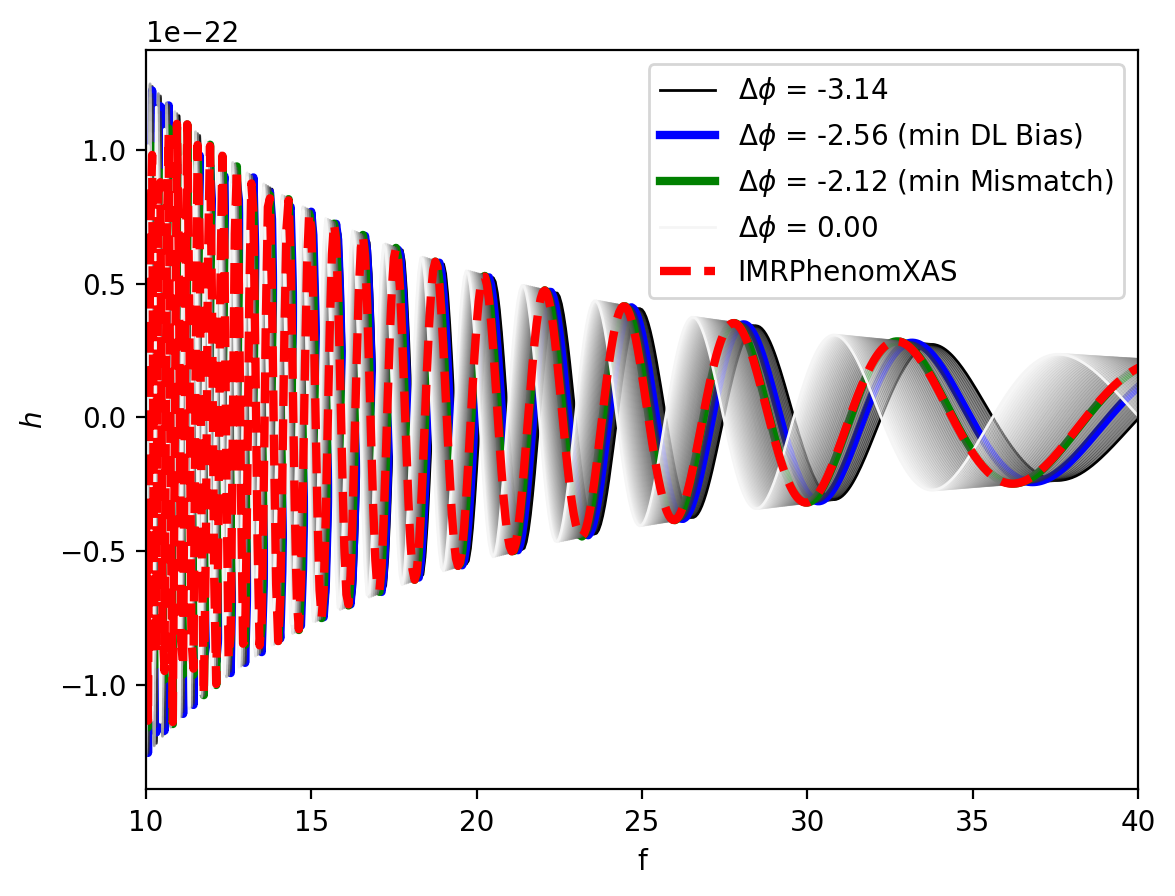

In [529]:
# Frequency Domain
d=0

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()
    h2_opt = net_tr_opt_d.detectors[0].hf

    if (i==0 or i+1==len(phis)):
        plt.plot(f, h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
    elif (i==np.argmax(overlaps)):
        plt.plot(f, h2_opt, lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
    elif (i==np.argmin(DL_biases)):
        plt.plot(f, h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        plt.plot(f, h2_opt, lw=1, alpha=0.5)

plt.plot(f, h1, label='IMRPhenomXAS', c='r', ls='--', lw=3)
plt.xlabel('f')
plt.ylabel('$h$')
plt.legend()
plt.xlim(10, 40)
plt.show()

2023-12-25 12:48:39,140 - Network - INFO : Polarizations calculated.
2023-12-25 12:48:39,154 - Network - INFO : PSDs loaded.
2023-12-25 12:48:39,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:48:39,164 - Network - INFO : Detector responses calculated.
2023-12-25 12:48:39,170 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
2023-12-25 12:48:39,179 - Network - INFO : Polarizations calculated.
2023-12-25 12:48:39,192 - Network - INFO : PSDs loaded.
2023-12-25 12:48:39,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:48:39,203 - Network - INFO : Detector responses calculated.
2023-12-25 12:48:39,208 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

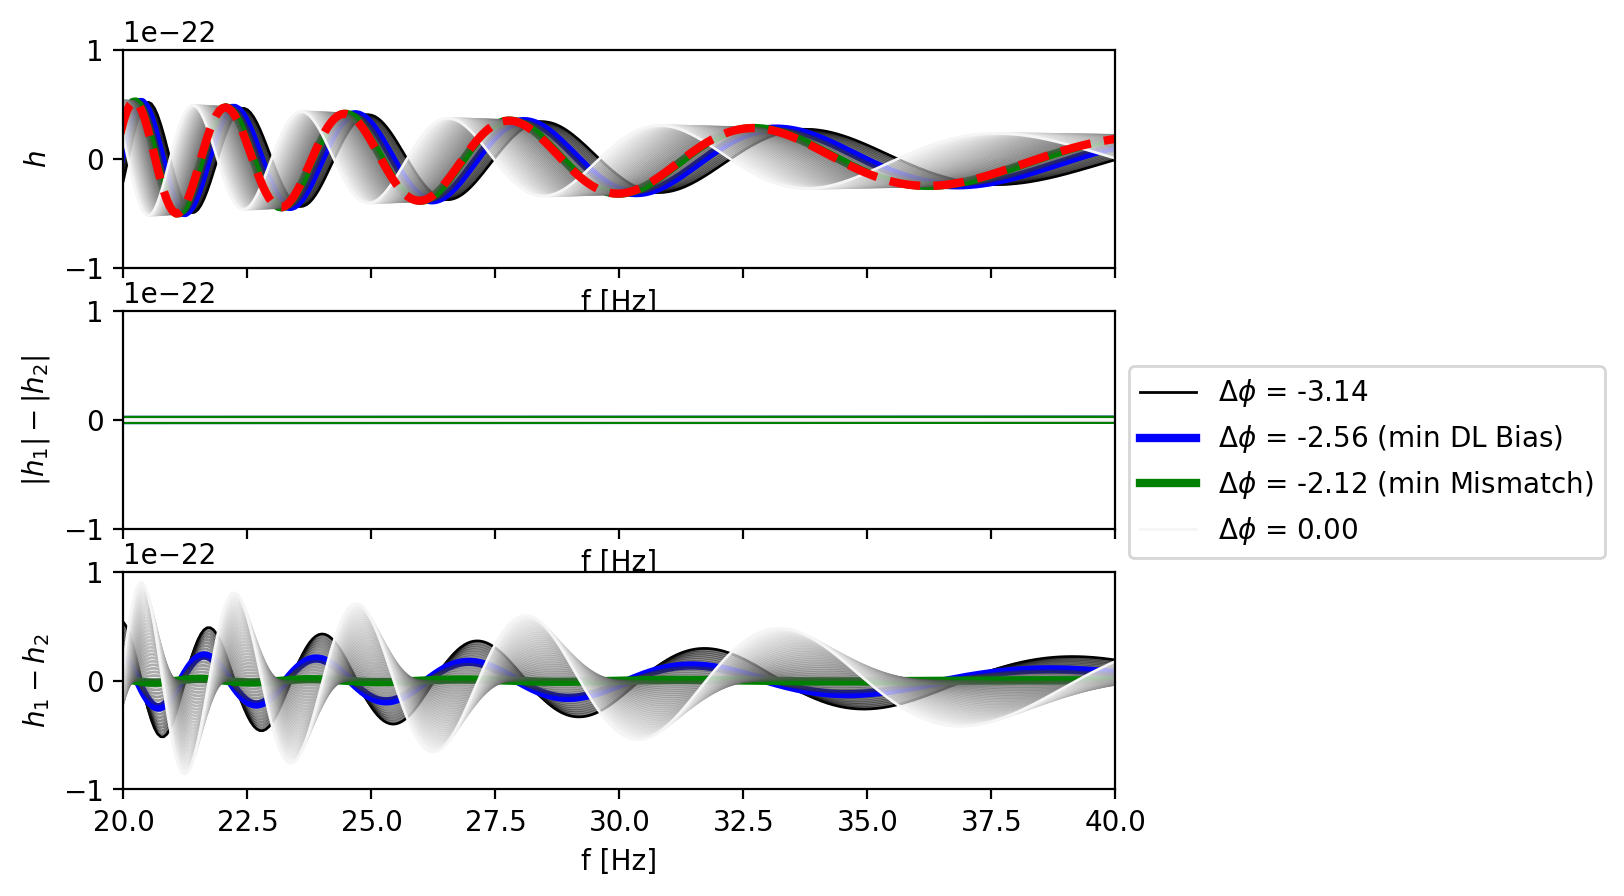

In [534]:
# Time Domain
d=0
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

# h1 = net_tr.detectors[d].hf

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()
    h2_opt = net_tr_opt_d.detectors[0].hf

    if (i==0 or i+1==len(phis)):
        ax[0].plot(f, h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
        ax[1].plot(f, np.abs(h1) - np.abs(h2_opt), lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
        ax[2].plot(f, h1-h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')

    elif (i==np.argmax(overlaps)):
        ax[0].plot(f, h2_opt, lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
        ax[1].plot(f, np.abs(h1) - np.abs(h2_opt), lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
        ax[2].plot(f, h1-h2_opt, lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')

    elif (i==np.argmin(DL_biases)):
        ax[0].plot(f, h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
        ax[1].plot(f, np.abs(h1) - np.abs(h2_opt), lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
        ax[2].plot(f, h1-h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        ax[0].plot(f, h2_opt, lw=1, alpha=0.5)
        ax[1].plot(f, np.abs(h1) - np.abs(h2_opt), lw=1, alpha=0.5)
        ax[2].plot(f, h1-h2_opt, lw=1, alpha=0.5)

ax[0].plot(f, h1, label='IMRPhenomXAS', c='r', ls='--', lw=3)
ax[0].set_xlabel('f [Hz]')
ax[0].set_ylabel('$h$')
ax[0].set_ylim(-1e-22, 1e-22)

# ax[1].plot(f, np.abs(h1), label='IMRPhenomXAS', c='r', ls='--', lw=3)
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$|h_1| - |h_2|$')
ax[1].set_ylim(-1e-22, 1e-22)

ax[2].set_xlabel('f [Hz]')
ax[2].set_ylabel('$h_1 - h_2$')
ax[2].set_ylim(-1e-22, 1e-22)

plt.legend(bbox_to_anchor=(1,1))
plt.xlim(20, 40)
plt.show()

2023-12-25 12:36:02,976 - Network - INFO : Polarizations calculated.
2023-12-25 12:36:02,991 - Network - INFO : PSDs loaded.
2023-12-25 12:36:02,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:36:03,028 - Network - INFO : Detector responses calculated.
2023-12-25 12:36:03,046 - Network - INFO : Polarizations calculated.
2023-12-25 12:36:03,070 - Network - INFO : Polarizations calculated.
2023-12-25 12:36:03,237 - Network - INFO : PSDs loaded.
2023-12-25 12:36:03,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:36:03,244 - Network - INFO : Detector responses calculated.
2023-12-25 12:36:03,249 - Network - INFO : Polarizations calculated.
2023-12-25 12:36:03,254 - Network - INFO : Polarizations calculated.
2023-12-25 12:36:03,270 - Network - INFO : PSDs loaded.
2023-12-25 12:36:03,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-25 12:36:03,276 - Network - INFO : Detector responses calculated.
2023-12-25 12:36:03,282 - Network 

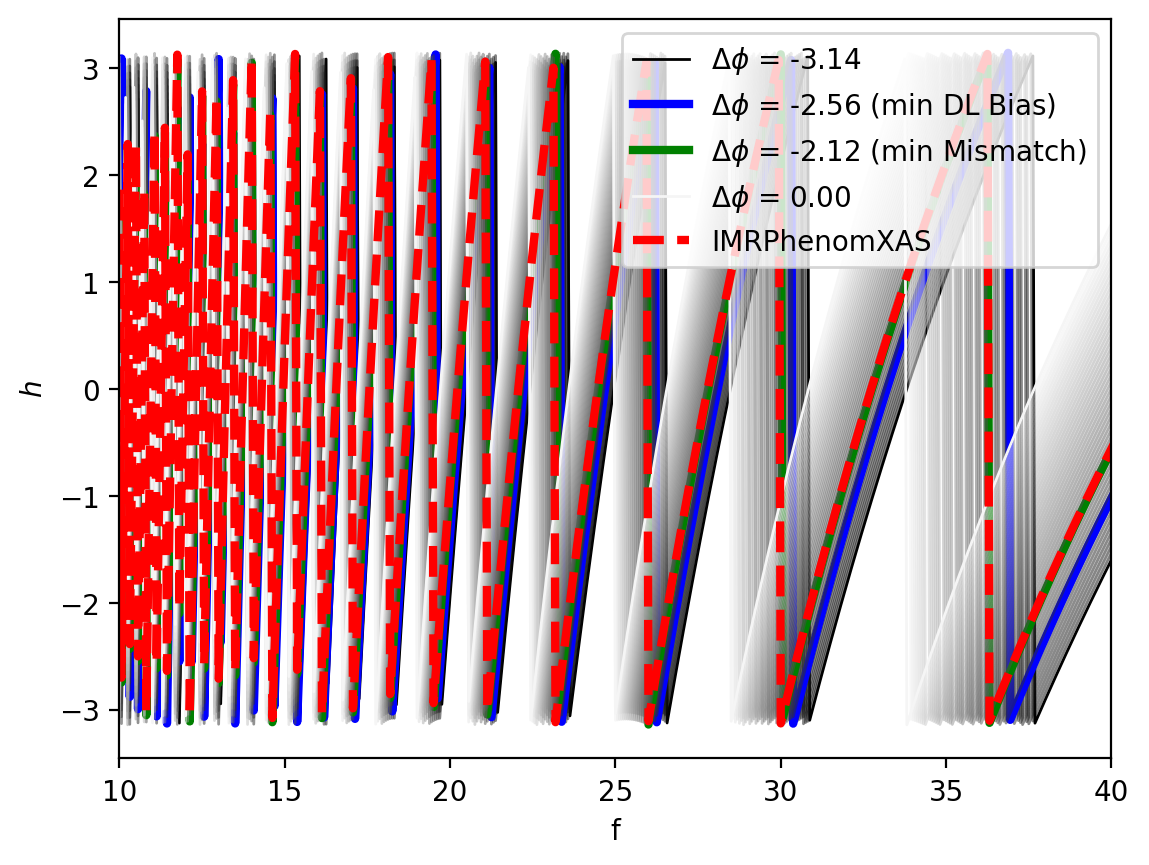

In [513]:
# Time Domain
d=0

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()
    h2_opt = net_tr_opt_d.detectors[0].hf

    if (i==0 or i+1==len(phis)):
        plt.plot(f, np.angle(h2_opt), lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
    elif (i==np.argmax(overlaps)):
        plt.plot(f, np.angle(h2_opt), lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
    elif (i==np.argmin(DL_biases)):
        plt.plot(f, np.angle(h2_opt), lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        plt.plot(f, np.angle(h2_opt), lw=1, alpha=0.5)

plt.plot(f, np.angle(h1), label='IMRPhenomXAS', c='r', ls='--', lw=3)
plt.xlabel('f')
plt.ylabel('$h$')
plt.legend()
plt.xlim(10, 40)
plt.show()

# Define integrations using Better methods

## Test Integration Schemes

In [16]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# Sample data - replace this with your own dataset
x = np.arange(0, 10, 2**-4)
y = np.sin(x)

# Define an interpolating function using your data
analytic_result = np.cos(x[0]) - np.cos(x[-1])

# Perform integration using scipy.integrate.simpson
result= integrate.simpson(y, x=x)
print(f"Result of simpson integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")

print()

# Perform integration using scipy.integrate.quadrature
interp_func = interp1d(x, y, kind='cubic')
# Define the integration limits
a = x[0]
b = x[-1]
result, error = integrate.quadrature(interp_func, a, b)
print(f"Result of interpolated quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")

print()

# Scipy Quadrature Function
result, error = integrate.quadrature(np.sin, a, b)
print(f"Result of quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")


print()

# Manual Quadrature Integration
f_x = np.sin
order = 11
x_i, w_i = np.polynomial.legendre.leggauss(deg=order)
pre_factor = (b-a)/2.

result = pre_factor * np.sum(w_i * f_x(((b-a)*x_i + b + a)/2.))
print(f"Result of manual quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")


Result of simpson integration: 1.8714169907009077
Estimated error: -2.4325630904375602e-06

Result of interpolated quad integration: 1.8714124062662385
Estimated error: 1.7155942747420198e-08

Result of quad integration: 1.8714124387389732
Estimated error: -1.9604982116957076e-10

Result of manual quad integration: 1.8714124383670563
Estimated error: 2.6861357271252238e-12


## Manual Gauss-Legendre Integration

The Gaussian Quadrature integral for Gauss-Legendre polynomials is defined as
$$\int_{-1}^{+1} f(t) dt = \Sigma_i w_i f(x_i),$$
where $w_i$ and $x_i$ are some pre-computed weights and nodes for the $i^{th}$ degree representation of the integrand, respectively.

In practice, our integration is usually defined between arbitrary limits as
$$\int_a^b f(x) dx.$$


LINEAR TRANSFORMATION (x->t):

In order to change the limits of integration, we can perform a change of variables, such that 
$$ x = \frac{(b-a)t + (b+a)}{2},$$
$$ dx = \frac{b-a}{2} dt.$$

Then, we can express our arbitrary integral in the Gaussian Quadrature form as follows:
$$\int_a^b f(x) dx = \frac{b-a}{2} \int_{-1}^{+1} f\left(\frac{(b-a)t + (b+a)}{2}\right) dt,$$
or,
$$\int_a^b f(x) dx  = \frac{b-a}{2} \Sigma_i w_i f\left(\frac{(b-a)x_i + (b+a)}{2}\right).$$

In [146]:
# Manual Quadrature Integration with linear transformation of x->t
f_x = np.sin
a = 0.
b = 10.
order = 50
analytic_result = -(np.cos(b) - np.cos(a))


t_i, w_i = np.polynomial.legendre.leggauss(deg=order)
pre_factor = (b-a)/2.

x_i = ((b-a)*t_i + b + a)/2.

result = pre_factor * np.sum(w_i * f_x(x_i))
print(f"Result of manual quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")


Result of manual quad integration: 1.8390715290764361
Estimated error: 8.934563177487615e-15


Result of manual quad integration: 1.8390715290764272
Estimated error: 1.376405678694038e-14


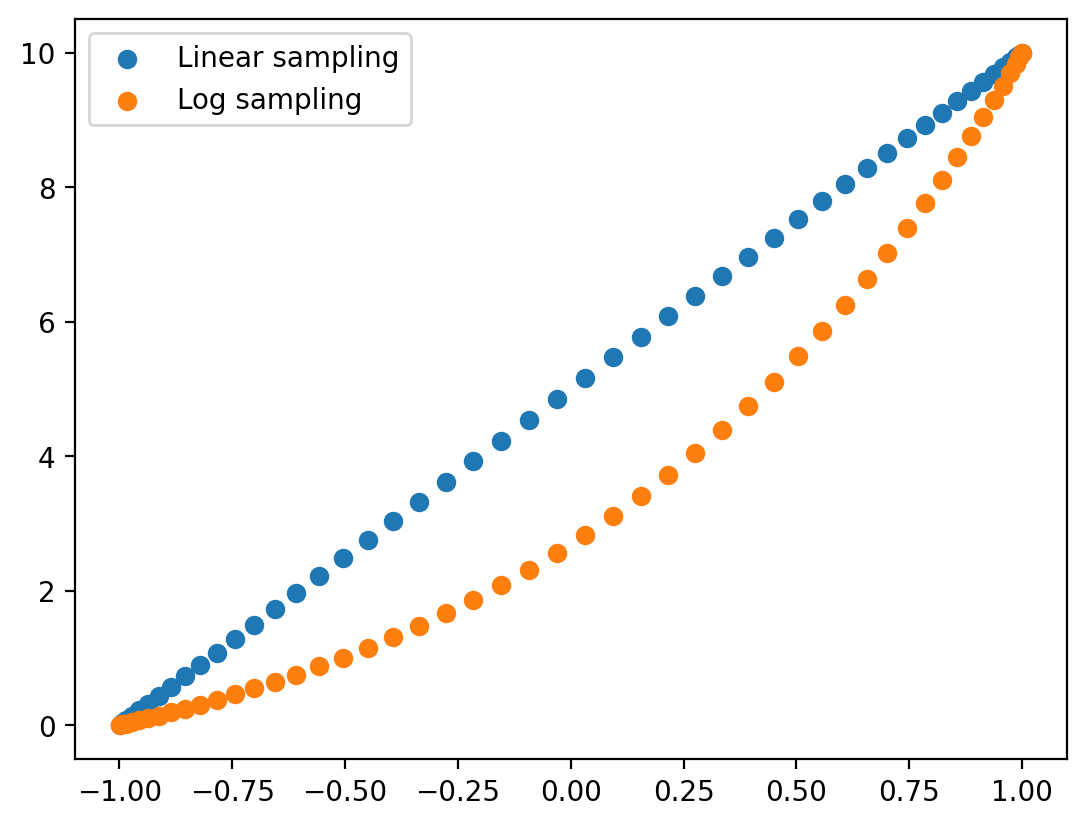

22
15


In [152]:
# Manual Quadrature Integration with exponential transformation of x->t
f_x = np.sin
a = 0.
b = 10.
order = 50

analytic_result = -(np.cos(b) - np.cos(a))

C = np.log((1-np.exp(2))/(a-b)) - 1
D = (b - a*np.exp(2))/(1 - np.exp(2))

t_i, w_i = np.polynomial.legendre.leggauss(deg=order)

T_i = np.exp(t_i-C) + D

result = np.sum(w_i * f_x(T_i) * np.exp(t_i-C))
print(f"Result of manual quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")

plt.scatter(t_i, x_i, label='Linear sampling')
plt.scatter(t_i, T_i, label='Log sampling')
plt.legend()
plt.show()

print(np.sum(T_i<2.0))
print(np.sum(x_i<2.0))

## Waveform Integration

In [4]:
network_label = 'HLV+'
 
inj_params = dict()
inj_params['Mc'] = 30.9
inj_params['eta'] = 0.247
inj_params['iota'] = np.pi/4
inj_params['chi1x'] = 0
inj_params['chi1y'] = 0
inj_params['chi1z'] = 0
inj_params['chi2x'] = 0
inj_params['chi2y'] = 0
inj_params['chi2z'] = 0
inj_params['DL'] = 475
inj_params['tc'] = 0
inj_params['phic'] = 0
inj_params['ra'] = np.pi/4
inj_params['dec'] = np.pi/4
inj_params['psi'] = np.pi/4
inj_params['gmst0'] = 0
inj_params['phiRef'] = 0

d_f = 1/16
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)

conv_cos = ('iota','dec')
conv_log = ('Mc','DL')
 
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
deriv_variables = ['log_Mc', 'eta', 'log_DL', 'tc', 'phic', 'cos_iota', 'ra', 'cos_dec', 'psi']

arnab_opt_bias = np.array([-1.31714324e-03, -2.53070629e-03, -1.29260647e-02, 2.33387974e-04, -2.43714891e-02, -8.23804703e-03, 4.42655777e-05, -1.40069160e-05, -2.42399781e-02])

arnab_unopt_bias = np.array([1.30937195e-02, 3.38632109e-02, 1.74124245e+00, -2.14910145e-03, 3.90542706e-01, 2.64436484e-01, -1.87088785e-03, 8.53396225e-04, -6.38689364e-02])

In [5]:
net_ap = gwnet.get_network_response(inj_params=inj_params, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant='IMRPhenomD', network_spec=['A+_H'], 
    conv_cos = ('iota','dec'),
    conv_log = ('Mc','DL'),
    calc_derivs=False, calc_fisher=False
    )

net_tr = gwnet.get_network_response(inj_params=inj_params, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant='IMRPhenomXAS', network_spec=['A+_H'],
    conv_cos = ('iota','dec'),
    conv_log = ('Mc','DL'), 
    calc_derivs=False, calc_fisher=False
    )

h1 = net_tr.detectors[0].hf
h2 = net_ap.detectors[0].hf
f = net_ap.detectors[0].f
df = f[1]-f[0]
Sn = net_ap.detectors[0].psd

2023-12-24 11:34:07,414 - Network - INFO : Polarizations calculated.
2023-12-24 11:34:07,424 - Network - INFO : PSDs loaded.
2023-12-24 11:34:07,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 11:34:07,456 - Network - INFO : Detector responses calculated.
2023-12-24 11:34:07,459 - Network - INFO : SNRs calculated.
2023-12-24 11:34:07,465 - Network - INFO : Polarizations calculated.
2023-12-24 11:34:07,474 - Network - INFO : PSDs loaded.
2023-12-24 11:34:07,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 11:34:07,482 - Network - INFO : Detector responses calculated.
2023-12-24 11:34:07,484 - Network - INFO : SNRs calculated.


['A+_H']
['A+_H']


### Test Convergence of Simpsons Rule

In [191]:
d_fs = [2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9, 2**-10]

h_norms = np.zeros(len(d_fs))
h_norms_div = np.zeros(len(d_fs))

for i, d_f in enumerate(d_fs):
    net_ap = gwnet.get_network_response(inj_params=inj_params, 
        deriv_symbs_string=deriv_symbs_string,
        f_min=f_low, f_max=f_high, d_f=d_f,
        approximant='IMRPhenomD', network_spec=['A+_H'], 
        conv_cos = ('iota','dec'),
        conv_log = ('Mc','DL'),
        calc_derivs=False, calc_fisher=False
        )

    net_tr = gwnet.get_network_response(inj_params=inj_params, 
        deriv_symbs_string=deriv_symbs_string,
        f_min=f_low, f_max=f_high, d_f=d_f,
        approximant='IMRPhenomXAS', network_spec=['A+_H'],
        conv_cos = ('iota','dec'),
        conv_log = ('Mc','DL'), 
        calc_derivs=False, calc_fisher=False
        )


    h1 = net_tr.detectors[0].hf
    h2 = net_ap.detectors[0].hf
    f = net_ap.detectors[0].f
    df = f[1]-f[0]
    Sn = net_ap.detectors[0].psd

    h_norms[i] = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    h_norms_div[i] = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn /h_norms[i], x=f))



2023-12-24 13:22:58,406 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,413 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,418 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,419 - Network - INFO : SNRs calculated.
2023-12-24 13:22:58,423 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,430 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,436 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,438 - Network - INFO : SNRs calculated.
2023-12-24 13:22:58,443 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,454 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,470 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,475 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 13:22:58,611 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,620 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,623 - Network - INFO : SNRs calculated.
2023-12-24 13:22:58,635 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,643 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,656 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,661 - Network - INFO : SNRs calculated.
2023-12-24 13:22:58,671 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,679 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,693 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,698 - Network - INFO : SNRs calculated.
2023-12-24 13:22:58,719 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-24 13:22:58,868 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:58,881 - Network - INFO : PSDs loaded.
2023-12-24 13:22:58,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:58,945 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:58,965 - Network - INFO : SNRs calculated.
2023-12-24 13:22:59,000 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:59,014 - Network - INFO : PSDs loaded.
2023-12-24 13:22:59,032 - Network - INFO : Antenna patterns and LPFs loaded.


['A+_H']
['A+_H']


2023-12-24 13:22:59,067 - Network - INFO : Detector responses calculated.
2023-12-24 13:22:59,087 - Network - INFO : SNRs calculated.
2023-12-24 13:22:59,184 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:59,207 - Network - INFO : PSDs loaded.
2023-12-24 13:22:59,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:59,318 - Network - INFO : Detector responses calculated.


['A+_H']


2023-12-24 13:22:59,355 - Network - INFO : SNRs calculated.
2023-12-24 13:22:59,416 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:59,439 - Network - INFO : PSDs loaded.
2023-12-24 13:22:59,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:22:59,543 - Network - INFO : Detector responses calculated.


['A+_H']


2023-12-24 13:22:59,585 - Network - INFO : SNRs calculated.
2023-12-24 13:22:59,784 - Network - INFO : Polarizations calculated.
2023-12-24 13:22:59,827 - Network - INFO : PSDs loaded.


['A+_H']


2023-12-24 13:22:59,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:23:00,033 - Network - INFO : Detector responses calculated.
2023-12-24 13:23:00,105 - Network - INFO : SNRs calculated.
2023-12-24 13:23:00,231 - Network - INFO : Polarizations calculated.
2023-12-24 13:23:00,262 - Network - INFO : PSDs loaded.


['A+_H']


2023-12-24 13:23:00,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:23:00,456 - Network - INFO : Detector responses calculated.
2023-12-24 13:23:00,532 - Network - INFO : SNRs calculated.


In [192]:
h_norms

array([39.23210456, 39.23189379, 39.23185863, 39.23188588, 39.23188829,
       39.23188904, 39.23188945, 39.23188926, 39.2318892 , 39.2318892 ])

### Gauss-Legendre Integration

In [200]:
# Sample original waveforms with very high precision to effectively sample x_i later
d_f = 2**-12
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)


net_ap_quad = network.Network(network_spec=network_label)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap_quad.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

use_rot = 0

net_ap_quad.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_ap_quad.calc_wf_polarizations()
net_ap_quad.setup_ant_pat_lpf_psds()
net_ap_quad.calc_det_responses()
net_ap_quad.calc_snrs()


net_tr_quad = network.Network(network_spec=network_label)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr_quad.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

net_tr_quad.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr_quad.calc_wf_polarizations()
net_tr_quad.setup_ant_pat_lpf_psds()
net_tr_quad.calc_det_responses()


2023-12-24 13:24:36,144 - Network - INFO : Polarizations calculated.
2023-12-24 13:24:36,541 - Network - INFO : PSDs loaded.
2023-12-24 13:24:37,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:24:39,268 - Network - INFO : Detector responses calculated.
2023-12-24 13:24:40,116 - Network - INFO : SNRs calculated.
2023-12-24 13:24:40,899 - Network - INFO : Polarizations calculated.
2023-12-24 13:24:41,290 - Network - INFO : PSDs loaded.
2023-12-24 13:24:42,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:24:44,118 - Network - INFO : Detector responses calculated.


#### Linear Spacing

In [209]:
# Linear Spacing
a = f_low
b = f_high

order = 50

x_i, w_i = np.polynomial.legendre.leggauss(deg=order)

# Assign the frequencies to an array
f_i = ((b-a)*x_i + b + a)/2.

In [211]:
# check that f_i can be found in the gwbench frequency series
print(len(f_i))
round_int = 3
f_i_mask = (np.in1d(np.round(f, round_int), np.round(f_i, round_int)))

unique, idx = np.unique(np.round(f[f_i_mask], round_int), return_index=True)
f_i_mask_2 = np.in1d(f[f_i_mask], f[f_i_mask][idx])

print(f[f_i_mask][f_i_mask_2].shape)
# print(f[f_i_mask][f_i_mask_2])


50
(50,)


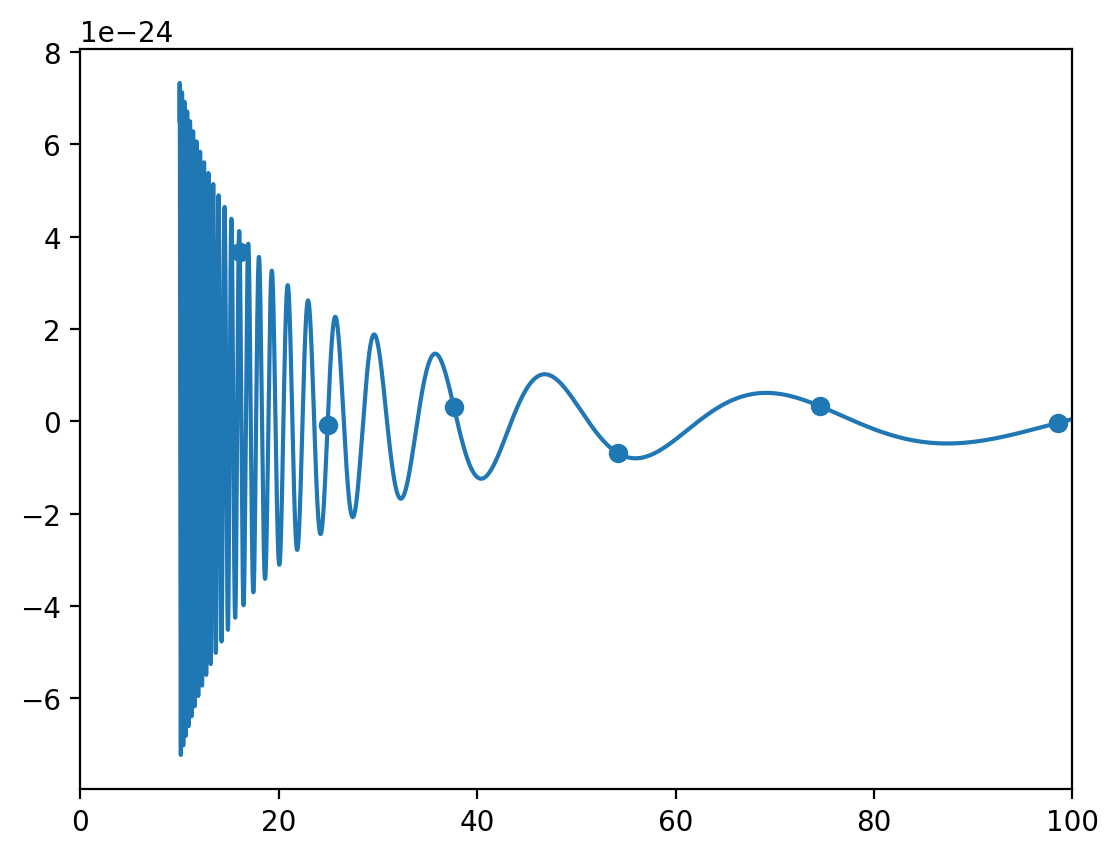

In [212]:
plt.scatter(net_tr_quad.detectors[0].f[f_i_mask][f_i_mask_2], net_tr_quad.detectors[0].hf[f_i_mask][f_i_mask_2])
plt.plot(net_tr.detectors[0].f, net_tr.detectors[0].hf)
plt.xlim(0, 100)
plt.show()

In [214]:
h1_i = net_tr_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
h2_i = net_ap_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
Sn_i = net_ap_quad.detectors[0].psd[f_i_mask][f_i_mask_2]

f_x_i = h1_i * np.conjugate(h1_i) / Sn_i

pre_factor = (b-a)/2.
result = pre_factor * np.sum(w_i * f_x_i)

print(4*np.real(result))

39.23560439079902


#### Log Spacing

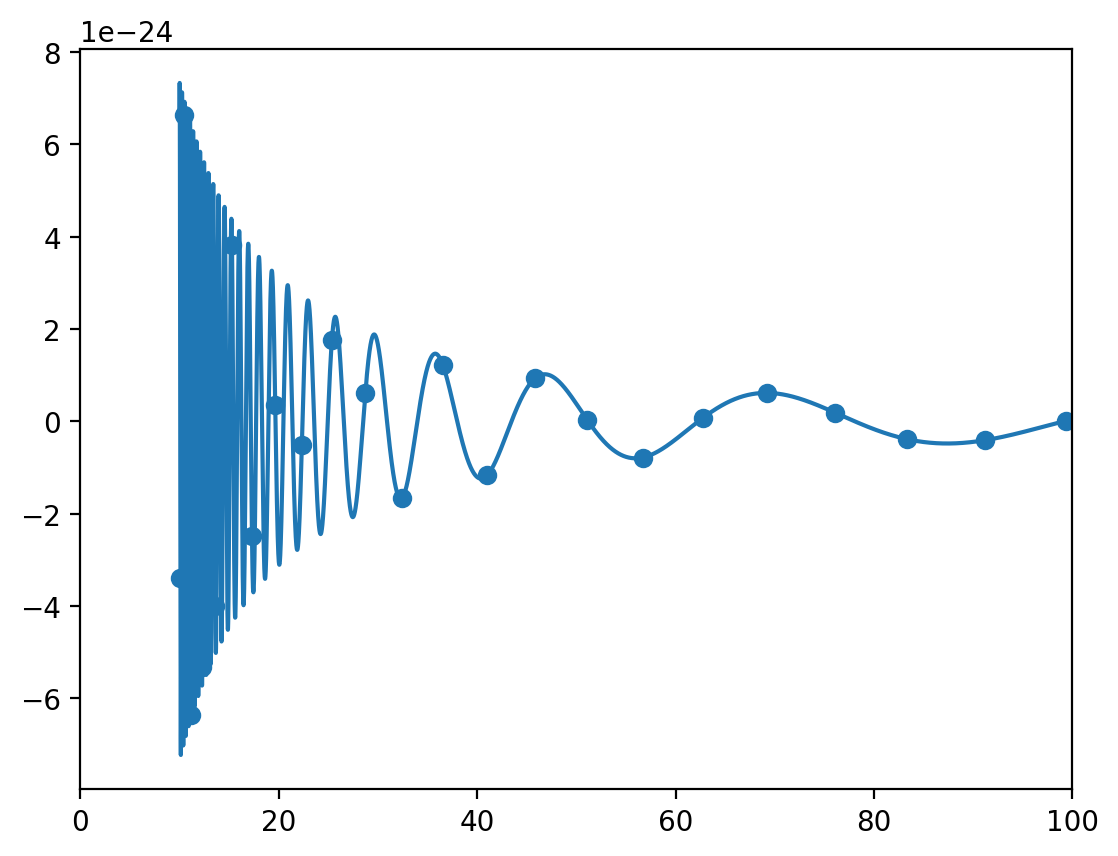

39.232215556092065


In [208]:
# Log Spacing
a = f_low
b = f_high
# b = 512

order = 99


C = np.log((1-np.exp(2))/(a-b)) - 1
D = (b - a*np.exp(2))/(1 - np.exp(2))

t_i, w_i = np.polynomial.legendre.leggauss(deg=order)

f_i = np.exp(t_i-C) + D

# check that f_i can be found in the gwbench frequency series
round_int = 4
f_i_mask = (np.in1d((np.round(f, round_int)), np.round(f_i, round_int)))

##
# DISCARD REPEATED FREQUENCIES USING np.unique() or something
unique, idx = np.unique(np.round(f[f_i_mask], round_int), return_index=True)
f_i_mask_2 = np.in1d(f[f_i_mask], f[f_i_mask][idx])
##


plt.scatter(net_tr_quad.detectors[0].f[f_i_mask][f_i_mask_2], net_tr_quad.detectors[0].hf[f_i_mask][f_i_mask_2])
plt.plot(net_tr.detectors[0].f, net_tr.detectors[0].hf)
plt.xlim(0, 100)
plt.show()


h1_i = net_tr_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
h2_i = net_ap_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
Sn_i = net_ap_quad.detectors[0].psd[f_i_mask][f_i_mask_2]

f_x_i = h1_i * np.conjugate(h1_i) / Sn_i


result = np.sum(w_i * f_x_i * np.exp(t_i-C))


print(4*np.real(result))

In [217]:
# Log Spacing
a = f_low
b = f_high
# b = 512

orders = np.arange(40, 90, 5)
results_o = np.zeros(len(orders))

C = np.log((1-np.exp(2))/(a-b)) - 1
D = (b - a*np.exp(2))/(1 - np.exp(2))

for o, order in enumerate(orders):
    t_i, w_i = np.polynomial.legendre.leggauss(deg=order)

    f_i = np.exp(t_i-C) + D

    # check that f_i can be found in the gwbench frequency series
    round_int = 3
    f_i_mask = (np.in1d((np.round(f, round_int)), np.round(f_i, round_int)))

    ##
    # DISCARD REPEATED FREQUENCIES USING np.unique() or something
    unique, idx = np.unique(np.round(f[f_i_mask], round_int), return_index=True)
    f_i_mask_2 = np.in1d(f[f_i_mask], f[f_i_mask][idx])
    ##


    h1_i = net_tr_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
    h2_i = net_ap_quad.detectors[0].hf[f_i_mask][f_i_mask_2]
    Sn_i = net_ap_quad.detectors[0].psd[f_i_mask][f_i_mask_2]

    f_x_i = h1_i * np.conjugate(h1_i) / Sn_i

    result = np.sum(w_i * f_x_i * np.exp(t_i-C))
    results_o[o] = 4*np.real(result)

In [218]:
results_o

array([39.22100706, 39.23626865, 39.22643704, 39.23247425, 39.23233152,
       39.22902427, 39.23242297, 39.23208117, 39.2305387 , 39.2318085 ])

The result doesn't converge using the quad method.

In [193]:
h_norms

array([39.23210456, 39.23189379, 39.23185863, 39.23188588, 39.23188829,
       39.23188904, 39.23188945, 39.23188926, 39.2318892 , 39.2318892 ])

### Gauss-Legendre, interpolated

In [222]:
# Sample original waveforms with very high precision to effectively sample x_i later
d_f = 2**-13
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)


net_ap_quad = network.Network(network_spec=network_label)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap_quad.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

use_rot = 0

net_ap_quad.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_ap_quad.calc_wf_polarizations()
net_ap_quad.setup_ant_pat_lpf_psds()
net_ap_quad.calc_det_responses()
net_ap_quad.calc_snrs()


net_tr_quad = network.Network(network_spec=network_label)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr_quad.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

net_tr_quad.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr_quad.calc_wf_polarizations()
net_tr_quad.setup_ant_pat_lpf_psds()
net_tr_quad.calc_det_responses()


2023-12-24 13:34:19,697 - Network - INFO : Polarizations calculated.
2023-12-24 13:34:20,413 - Network - INFO : PSDs loaded.
2023-12-24 13:34:22,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:34:27,714 - Network - INFO : Detector responses calculated.
2023-12-24 13:34:29,785 - Network - INFO : SNRs calculated.
2023-12-24 13:34:31,667 - Network - INFO : Polarizations calculated.
2023-12-24 13:34:32,439 - Network - INFO : PSDs loaded.
2023-12-24 13:34:34,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-24 13:34:40,669 - Network - INFO : Detector responses calculated.


In [223]:
# Log Spacing
a = f_low
b = f_high
# b = 512

order = 99


C = np.log((1-np.exp(2))/(a-b)) - 1
D = (b - a*np.exp(2))/(1 - np.exp(2))

t_i, w_i = np.polynomial.legendre.leggauss(deg=order)

f_i = np.exp(t_i-C) + D


h1_i = net_tr_quad.detectors[0].hf
h2_i = net_ap_quad.detectors[0].hf
Sn_i = net_ap_quad.detectors[0].psd
f_x = h1_i * np.conjugate(h1_i) / Sn_i

interp_func = interpolate.interp1d(f, f_x, kind='cubic')

f_x_i = interp_func(f_i)

result = np.sum(w_i * f_x_i * np.exp(t_i-C))


print(4*np.real(result))

39.23223525518185


In [221]:
h_norms

array([39.23210456, 39.23189379, 39.23185863, 39.23188588, 39.23188829,
       39.23188904, 39.23188945, 39.23188926, 39.2318892 , 39.2318892 ])